In [88]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statistics
import sklearn.metrics as metrics
import sklearn.metrics as f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold

In [33]:
bids_df= pd.read_csv('data/bids.csv')
train_df = pd.read_csv('data/train.csv')
test_df= pd.read_csv('data/test.csv')

In [34]:
bids_df

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3
...,...,...,...,...,...,...,...,...,...
7656329,7656329,626159dd6f2228ede002d9f9340f75b7puk8d,3e64w,jewelry,phone91,9709222052631578,ru,140.204.227.63,cghhmomsaxi6pug
7656330,7656330,a318ea333ceee1ba39a494476386136a826dv,xn0y0,mobile,phone236,9709222052631578,pl,24.232.159.118,wgggpdg2gx5pesn
7656331,7656331,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,gja6c,sporting goods,phone80,9709222052631578,za,80.237.28.246,5xgysg14grlersa
7656332,7656332,d4bd412590f5106b9d887a43c51b254eldo4f,hmwk8,jewelry,phone349,9709222052631578,my,91.162.27.152,bhtrek44bzi2wfl


# Feature Engineering

In [35]:
bids_unique= bids_df.groupby('bidder_id').nunique()
bids_unique = bids_unique.drop(["bid_id"],axis = 1)

#### From bids_unique dataframe, we may be interested in the number of times a bidder has 
1. Bidded in a different auction
2. Bidded from a different url
3. Bidded on a different device
4. Bidded from a different country

In [36]:
bids_unique

,auction,merchandise,device,time,country,ip,url
bidder_id,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1
002d229ffb247009810828f648afc2ef593rb,1,1,2,2,1,1,1
0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,1,3,3,1,3,2
00486a11dff552c4bd7696265724ff81yeo9v,13,1,8,20,1,10,7
...,...,...,...,...,...,...,...
ffbc0fdfbf19a8a9116b68714138f2902cc13,637,1,792,23487,102,18726,8039
ffc4e2dd2cc08249f299cab46ecbfacfobmr3,15,1,13,22,6,18,12
ffd29eb307a4c54610dd2d3d212bf3bagmmpl,1,1,1,1,1,1,1


In [37]:
bids_df_count= bids_df.groupby("bidder_id")
counts= bids_df_count['url'].count().reset_index().rename(columns = {'url':'num_bids'})

#### From counts dataframe, we know the number of times that a unique bidder has performed a bid 

In [38]:
counts

,bidder_id,num_bids
0,001068c415025a009fee375a12cff4fcnht8y,1
1,002d229ffb247009810828f648afc2ef593rb,2
2,0030a2dd87ad2733e0873062e4f83954mkj86,1
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3
4,00486a11dff552c4bd7696265724ff81yeo9v,20
...,...,...
6609,ffbc0fdfbf19a8a9116b68714138f2902cc13,25075
6610,ffc4e2dd2cc08249f299cab46ecbfacfobmr3,22
6611,ffd29eb307a4c54610dd2d3d212bf3bagmmpl,1
6612,ffd62646d600b759a985d45918bd6f0431vmz,664


#### Joining the new features together with the training dataset

In [39]:
new_train = train_df.merge(bids_unique, how= 'left', on = 'bidder_id')
new_train = new_train.merge(counts, how= 'left')
new_train.fillna(0,inplace = True)

new_test = test_df.merge(bids_unique, how= 'left', on = 'bidder_id')
new_test = new_test.merge(counts, how= 'left')
new_test.fillna(0,inplace = True)

#### Check that the size new training and test dataset is the same as the old training and test dataset

In [40]:
print("Size of old train: " + str(train_df.shape))
print("Size of new train: " + str(new_train.shape))
print("Size of old test: " + str(test_df.shape))
print("Size of new test: " + str(new_test.shape))

Size of old train: (2013, 4)
Size of new train: (2013, 12)
Size of old test: (4700, 3)
Size of new test: (4700, 11)


#### Count of number of first and last bids for each bidder

In [41]:
auctions = bids_df.groupby('auction')
first_bid_list = set(auctions.first()['bidder_id'])
last_bid_list = set(auctions.last()['bidder_id'])

In [42]:
# functions to add a counter if a particular bidder id is in the first and/or last bid
def check_first_bid(dummy):
    count = 0
    for bidder_id in first_bid_list:
        if(dummy == bidder_id):
            count+=1
    return count
        
def check_last_bid(dummy):
    count = 0
    for bidder_id in last_bid_list:
        if(dummy == bidder_id):
            count+=1
    return count

In [43]:
num_first_bids_train = new_train['bidder_id'].apply(func = check_first_bid)
num_last_bids_train = new_train['bidder_id'].apply(func = check_last_bid)

num_first_bids_test = new_test['bidder_id'].apply(func = check_first_bid)
num_last_bids_test = new_test['bidder_id'].apply(func = check_last_bid)

In [44]:
# joining the new train and test with the number of first and last bids
new_train['num_first_bids'] = num_first_bids_train
new_train['num_last_bids'] = num_last_bids_train
new_train

,bidder_id,payment_account,address,outcome,auction,merchandise,device,time,country,ip,url,num_bids,num_first_bids,num_last_bids
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0,24.0,0,0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0,3.0,0,0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0,4.0,0,0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0,155.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,a1f85275793c4a782f0a668711f41b927ivc9,e6882cf204a9482edd042b6e31791dfctxzx8,0.0,25.0,1.0,4.0,33.0,4.0,5.0,2.0,36.0,1,0
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,a3d2de7675556553a5f08e4c88d2c2286s1m2,b9b03d5a127eb07aeb9163cdcf524e1344ac9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,a3d2de7675556553a5f08e4c88d2c22856leq,d02c2b288b8aabd79ff47118aff41a2dqwzwc,0.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,0,0
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,fd87037ce0304077079c749f420f0b4c54uo0,f030a221726fbcdfc4dc7dfd1b381a112hieq,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0


In [45]:
new_test['num_first_bids'] = num_first_bids_test
new_test['num_last_bids'] = num_last_bids_test
new_test

,bidder_id,payment_account,address,auction,merchandise,device,time,country,ip,url,num_bids,num_first_bids,num_last_bids
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c,3.0,1.0,2.0,4.0,3.0,4.0,3.0,4.0,0,0
1,a921612b85a1494456e74c09393ccb65ylp4y,a3d2de7675556553a5f08e4c88d2c228rs17i,a3d2de7675556553a5f08e4c88d2c228klidn,2.0,1.0,3.0,3.0,2.0,2.0,1.0,3.0,0,0
2,6b601e72a4d264dab9ace9d7b229b47479v6i,925381cce086b8cc9594eee1c77edf665zjpl,a3d2de7675556553a5f08e4c88d2c228aght0,14.0,1.0,4.0,17.0,3.0,4.0,2.0,17.0,0,0
3,eaf0ed0afc9689779417274b4791726cn5udi,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat,90.0,1.0,81.0,148.0,14.0,129.0,80.0,148.0,0,0
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,a3d2de7675556553a5f08e4c88d2c228dtdkd,c3b363a3c3b838d58c85acf0fc9964cb4pnfa,20.0,1.0,17.0,23.0,2.0,17.0,1.0,23.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4695,bef56983ba78b2ee064443ae95972877jfkyd,0f235a6dfea5a5885d63968826b748b4q4dra,a98a4841db165de919d29cb49d0bc306cq21h,41.0,1.0,9.0,466.0,5.0,22.0,4.0,983.0,0,0
4696,4da45cc915c32d4368ac7e773d92d4affwqrr,9e0adf7481c422654d4d0a849e0e50abiumen,e23d9777cddc347de82d839b2e54b22ecopkp,32.0,1.0,29.0,66.0,10.0,49.0,18.0,66.0,0,0
4697,0d0e6220bf59ab9a0c5b5987fb2c34a9p33f9,7df4ebd184668b4257f740b11d4519afq7kr1,b650404e1ab5d177020221277c3e9306qegyl,419.0,1.0,376.0,2156.0,86.0,1460.0,1049.0,2162.0,1,1
4698,4981c32c54dde65b79dbc48fd9ab6457caqze,a3d2de7675556553a5f08e4c88d2c2284qlm0,9c35320088eaf32046a51a96ebb2e658i479u,5.0,1.0,4.0,5.0,1.0,5.0,2.0,5.0,0,0


In [46]:
#entropy
def log_entropy(x):
    e = np.sum(np.log(np.array(range(1,np.sum(x)))))
    for i in x:
        e -= np.sum(np.log(np.array(range(1,i))))
    return e

In [47]:
entropy_df = new_train.copy()
entropy_df['ip_entropy'] = 0
entropy_df['url_entropy'] = 0
# entropy_df
for bidder in entropy_df['bidder_id']:
    temp_df = bids_df[bids_df['bidder_id'] == bidder][['ip','url']]
    entropy_df.loc[entropy_df[entropy_df['bidder_id'] == bidder].index, ['ip_entropy', 'url_entropy']] = \
                    round(log_entropy(temp_df.ip.groupby(temp_df.ip).count()),4), \
                    round(log_entropy(temp_df.url.groupby(temp_df.url).count()),4)
    
entropy_df = entropy_df[['bidder_id', 'ip_entropy', 'url_entropy']]
entropy_df

,bidder_id,payment_account,address,outcome,auction,merchandise,device,time,country,ip,url,num_bids,num_first_bids,num_last_bids,ip_entropy,url_entropy
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0,24.0,0,0,49.8149,0.0000
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0,3.0,0,0,0.6931,0.6931
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0,4.0,0,0,1.7918,1.0986
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.0000,0.0000
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0,155.0,0,0,601.0291,460.9263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,a1f85275793c4a782f0a668711f41b927ivc9,e6882cf204a9482edd042b6e31791dfctxzx8,0.0,25.0,1.0,4.0,33.0,4.0,5.0,2.0,36.0,1,0,26.0870,9.8851
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,a3d2de7675556553a5f08e4c88d2c2286s1m2,b9b03d5a127eb07aeb9163cdcf524e1344ac9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.0000,0.0000
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,a3d2de7675556553a5f08e4c88d2c22856leq,d02c2b288b8aabd79ff47118aff41a2dqwzwc,0.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,0,0,0.0000,0.0000
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,fd87037ce0304077079c749f420f0b4c54uo0,f030a221726fbcdfc4dc7dfd1b381a112hieq,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.0000,0.0000


In [ ]:
# median time between a user’s bid and his previous bid (yk)

In [ ]:
# minimum and median times between a user’s bid and previous bid by another user in the same auction (yk)

In [ ]:
# proportion of each bidder’s bids that were in each day (bren)

In [ ]:
# proportion of each bidder’s bids that were in each of 8 3-hour time slots (bren)

In [ ]:
# mean time of day for the bids of each bidder (yk)

In [ ]:
# maximum number of auctions a bidder has participated in, in an hour (wq)

In [ ]:
# the maximum number of bids in a 20 min span (guang)

In [ ]:
# most frequent used url for each bidder

In [ ]:
# number of bids placed by the user on each of the three weekdays in the data (guang)

In [48]:
# fraction of IPs used by a bidder which were also used by another user which was a bot (jf)
#bids per ip used by bots
bot_or_human = train_df
ip_used_by_bot = pd.merge(bids_df, bot_or_human[['bidder_id', 'outcome']], on='bidder_id', how='left')

# #make outcome num a float num
ip_used_by_bot['outcome'] = 1.0 * (ip_used_by_bot['outcome'] == 1)

#get unique ip by each bidder 
unique_ip_per_bidder = ip_used_by_bot.groupby(['ip', 'bidder_id']).outcome.mean().reset_index() 

#identify ips that are a bot
bot_ips = unique_ip_per_bidder.groupby('ip').outcome.sum().reset_index() 
bot_ips['num_bots_on_ip'] = bot_ips.outcome
bids = pd.merge(ip_used_by_bot, bot_ips[['ip', 'num_bots_on_ip']], on='ip', how='left')

#find out bidders that are using ips used by bots
bids['has_ip_used_by_a_bot'] = 1 * ((bids['num_bots_on_ip'] - bids['outcome']) >= 1) 

#drop bidders who are already identified as bots in train dataset
bids = bids.drop('outcome', 1)

#group by unique ip and bidder
unique_ip_per_bidder = bids.groupby(['bidder_id', 'ip']).has_ip_used_by_a_bot.mean().reset_index() 

#get bidder that has ips used by a bot
bot_ips = unique_ip_per_bidder.groupby('bidder_id').has_ip_used_by_a_bot.mean().reset_index()

#final dataframe
bot_or_human = pd.merge(bot_or_human, bot_ips[['bidder_id', 'has_ip_used_by_a_bot']], on='bidder_id', how='left')
bot_or_human['on_ip_that_has_a_bot_mean'] = bot_or_human['has_ip_used_by_a_bot'].fillna(0)
bot_or_human['has_ip_used_by_a_bot'] = 1*(bot_or_human['has_ip_used_by_a_bot'].fillna(0) > 0)
bot_or_human = bot_or_human[['bidder_id', 'on_ip_that_has_a_bot_mean']]
bot_or_human

<ipython-input-48-1af5c6ff741d>:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  bids = bids.drop('outcome', 1)


,bidder_id,payment_account,address,outcome,has_ip_used_by_a_bot,on_ip_that_has_a_bot_mean
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,1,0.400000
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,0,0.000000
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,1,1.000000
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1,1.000000
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,1,0.260163
...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,a1f85275793c4a782f0a668711f41b927ivc9,e6882cf204a9482edd042b6e31791dfctxzx8,0.0,1,0.800000
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,a3d2de7675556553a5f08e4c88d2c2286s1m2,b9b03d5a127eb07aeb9163cdcf524e1344ac9,0.0,0,0.000000
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,a3d2de7675556553a5f08e4c88d2c22856leq,d02c2b288b8aabd79ff47118aff41a2dqwzwc,0.0,1,0.500000
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,fd87037ce0304077079c749f420f0b4c54uo0,f030a221726fbcdfc4dc7dfd1b381a112hieq,0.0,1,1.000000


In [ ]:
# stdev of time per bid (skipz first)

In [51]:
# mean response time
def find_time_to_bid(auction_id, time):
    starttime = timing_dict[auction_id]['starttime']
    return int(time) - int(starttime)

end_auction_time= bids_df.groupby('auction').time.max().reset_index()
end_auction_time= end_auction_time.rename(columns= {'time': 'endtime'})

start_auction_time= bids_df.groupby('auction').time.min().reset_index()
start_auction_time= start_auction_time.rename(columns= {'time': 'starttime'})

start_end_times= pd.merge(start_auction_time, end_auction_time, on= 'auction', how= 'left')
start_end_times = start_end_times.set_index('auction')

timing_dict = start_end_times.to_dict('index')

start_auction_time= bids_df.groupby('auction').time.min().reset_index()
start_auction_time= start_auction_time.rename(columns= {'time': 'starttime'})
timing_dict = start_end_times.to_dict('index')

bids_df['time_to_bid'] = bids_df.apply(lambda row: find_time_to_bid(row['auction'], row['time']), axis=1)

bids_df_time = bids_df
bids_df_time_mean = bids_df_time.groupby('bidder_id')['time_to_bid'].mean().reset_index()
bids_df_time_mean

,bidder_id,time_to_bid
0,001068c415025a009fee375a12cff4fcnht8y,7.439058e+13
1,002d229ffb247009810828f648afc2ef593rb,1.455263e+11
2,0030a2dd87ad2733e0873062e4f83954mkj86,7.263689e+13
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,6.854544e+12
4,00486a11dff552c4bd7696265724ff81yeo9v,1.904773e+13
...,...,...
6609,ffbc0fdfbf19a8a9116b68714138f2902cc13,5.719356e+12
6610,ffc4e2dd2cc08249f299cab46ecbfacfobmr3,2.954407e+13
6611,ffd29eb307a4c54610dd2d3d212bf3bagmmpl,1.044305e+13
6612,ffd62646d600b759a985d45918bd6f0431vmz,5.369726e+12


In [52]:
# number of simul bids per bidder
results = bids_df.groupby(['bidder_id','time']).count()[bids_df.groupby(['bidder_id','time']).count()['bid_id'] > 1 ]
inst_resp = results.groupby("bidder_id").sum()
needed_df = bids_df.groupby(['bidder_id','time']).count()[bids_df.groupby(['bidder_id','time']).count()['bid_id'] > 0 ]
num_resp = needed_df.groupby("bidder_id").sum()
num_resp = num_resp.reset_index()
inst_resp = inst_resp.reset_index()
num_resp = num_resp[['bidder_id','bid_id']]
inst_resp = inst_resp[['bidder_id','bid_id']]
num_resp.rename(columns={"bid_id": "num_bids"}, inplace= True)
inst_resp.rename(columns={"bid_id": "inst_resp"}, inplace= True)
total_inst_resp = num_resp.merge(inst_resp, how= 'left',on='bidder_id')
total_inst_resp.fillna(0, inplace = True)
total_inst_resp['perc_inst_resp'] = total_inst_resp['inst_resp']/total_inst_resp['num_bids']
total_inst_resp.drop(axis = 1 , columns = 'num_bids', inplace=True)
total_inst_resp

,bidder_id,inst_resp,perc_inst_resp
0,001068c415025a009fee375a12cff4fcnht8y,0.0,0.000000
1,002d229ffb247009810828f648afc2ef593rb,0.0,0.000000
2,0030a2dd87ad2733e0873062e4f83954mkj86,0.0,0.000000
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.0,0.000000
4,00486a11dff552c4bd7696265724ff81yeo9v,0.0,0.000000
...,...,...,...
6609,ffbc0fdfbf19a8a9116b68714138f2902cc13,3068.0,0.122353
6610,ffc4e2dd2cc08249f299cab46ecbfacfobmr3,0.0,0.000000
6611,ffd29eb307a4c54610dd2d3d212bf3bagmmpl,0.0,0.000000
6612,ffd62646d600b759a985d45918bd6f0431vmz,0.0,0.000000


In [53]:
# one-hot encoding merchandise - working
one_hot = pd.get_dummies(bids_df['merchandise'])
one_hot_df = bids_df.join(one_hot)
one_hot_df = one_hot_df.drop('merchandise', axis=1)
# one_hot_df = one_hot_df.join(one_hot)
# one_hot_df = one_hot_df.rename(columns={1.0:'merchandise=1.0',2.0:'merchandise=2.0'})
one_hot_df.set_index("bidder_id", inplace=True)
one_hot_df = one_hot_df[['auto parts', 'books and music', 'clothing', 'computers',
       'furniture', 'home goods', 'jewelry', 'mobile', 'office equipment',
       'sporting goods']]
one_hot_df = one_hot_df.groupby("bidder_id").sum()
one_hot_df

,auto parts,books and music,clothing,computers,furniture,home goods,jewelry,mobile,office equipment,sporting goods
bidder_id,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
002d229ffb247009810828f648afc2ef593rb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
0030a2dd87ad2733e0873062e4f83954mkj86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
00486a11dff552c4bd7696265724ff81yeo9v,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
ffbc0fdfbf19a8a9116b68714138f2902cc13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25075.0,0.0,0.0
ffc4e2dd2cc08249f299cab46ecbfacfobmr3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0
ffd29eb307a4c54610dd2d3d212bf3bagmmpl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [54]:
# percent instant resp (skipz first)

In [55]:
# bids per auction
bids_auction_count= bids_df.groupby(["bidder_id", "auction"])
bids_auction_count_df = bids_auction_count.nunique().groupby("bidder_id").mean().reset_index()
bids_auction_count_df = pd.DataFrame(bids_auction_count_df, columns = ['bidder_id', 'bid_id', 'auction', 'merchandise', 
                                                                       'time', 'country', 'ip', 'url'])
bids_auction_count_df = bids_auction_count_df[['bidder_id','bid_id']]
bids_auction_count_df.rename(columns={"bid_id": "num_bids_per_auction"}, inplace= True)

In [56]:
# bids per device
bids_device_count= bids_df.groupby(["bidder_id", "device"])
bids_device_count_df = bids_device_count.nunique().groupby("bidder_id").mean().reset_index()
bids_device_count_df = pd.DataFrame(bids_device_count_df, columns = ['bidder_id', 'bid_id', 'auction', 'merchandise', 
                                                                     'time', 'country', 'ip', 'url'])
bids_device_count_df = bids_device_count_df[['bidder_id','bid_id']]
bids_device_count_df.rename(columns={"bid_id": "num_bids_per_device"}, inplace= True)

In [57]:
# bids per country
bids_country_count= bids_df.groupby(["bidder_id", "country"])
bids_country_count_df = bids_country_count.nunique().groupby("bidder_id").mean().reset_index()
bids_country_count_df = pd.DataFrame(bids_country_count_df, columns = ['bidder_id', 'bid_id', 'auction', 'merchandise', 
                                                                       'time', 'country', 'ip', 'url'])
bids_country_count_df = bids_country_count_df[['bidder_id','bid_id']]
bids_country_count_df.rename(columns={"bid_id": "num_bids_per_country"}, inplace= True)

In [58]:
# bids per ip
bids_ip_count= bids_df.groupby(["bidder_id", "ip"])
bids_ip_count_df = bids_ip_count.nunique().groupby("bidder_id").mean().reset_index()
bids_ip_count_df = pd.DataFrame(bids_ip_count_df, columns = ['bidder_id', 'bid_id', 'auction', 
                                                             'merchandise', 'time', 'country', 'ip', 'url'])
bids_ip_count_df = bids_ip_count_df[['bidder_id','bid_id']]
bids_ip_count_df.rename(columns={"bid_id": "num_bids_per_ip"}, inplace= True)

In [59]:
# bids per url
bids_url_count= bids_df.groupby(["bidder_id", "url"])
bids_url_count_df = bids_url_count.nunique().groupby("bidder_id").mean().reset_index()
bids_url_count_df = pd.DataFrame(bids_url_count_df, columns = ['bidder_id', 'bid_id', 'auction', 'merchandise', 
                                                                     'time', 'country', 'ip', 'url'])
bids_url_count_df = bids_url_count_df[['bidder_id','bid_id']]
bids_url_count_df.rename(columns={"bid_id": "num_bids_per_url"}, inplace= True)

In [60]:
merged_df = bids_auction_count_df.merge(bids_device_count_df, how= 'left', on = 'bidder_id')
merged_df = merged_df.merge(bids_country_count_df, how= 'left', on = 'bidder_id')
merged_df = merged_df.merge(bids_ip_count_df, how= 'left', on = 'bidder_id')
merged_df = pd.DataFrame(merged_df)
merged_df.fillna(0,inplace = True)
merged_df 

,bidder_id,num_bids_per_auction,num_bids_per_device,num_bids_per_country,num_bids_per_ip
0,001068c415025a009fee375a12cff4fcnht8y,1.000000,1.000000,1.000000,1.000000
1,002d229ffb247009810828f648afc2ef593rb,2.000000,1.000000,2.000000,2.000000
2,0030a2dd87ad2733e0873062e4f83954mkj86,1.000000,1.000000,1.000000,1.000000
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,1.000000,1.000000,3.000000,1.000000
4,00486a11dff552c4bd7696265724ff81yeo9v,1.538462,2.500000,20.000000,2.000000
...,...,...,...,...,...
6609,ffbc0fdfbf19a8a9116b68714138f2902cc13,39.364207,31.660354,245.833333,1.339047
6610,ffc4e2dd2cc08249f299cab46ecbfacfobmr3,1.466667,1.692308,3.666667,1.222222
6611,ffd29eb307a4c54610dd2d3d212bf3bagmmpl,1.000000,1.000000,1.000000,1.000000
6612,ffd62646d600b759a985d45918bd6f0431vmz,12.072727,6.916667,664.000000,17.945946


#### Merging all features together again

In [68]:
merged_df_2 = new_train.merge(bids_df_time_mean, how= 'left',on='bidder_id')
merged_df_2 = merged_df_2.merge(total_inst_resp, how= 'left',on='bidder_id')
merged_df_2 = merged_df_2.merge(one_hot_df, how= 'left',on='bidder_id')
merged_df_2 = merged_df_2.merge(merged_df, how= 'left',on='bidder_id')
merged_df_2 = merged_df_2.merge(bot_or_human, how= 'left',on='bidder_id')
merged_df_2 = merged_df_2.merge(entropy_df, how= 'left',on='bidder_id')
merged_df_2

,bidder_id,payment_account,address,outcome,auction,merchandise,device,time,country,ip,...,mobile,office equipment,sporting goods,num_bids_per_auction,num_bids_per_device,num_bids_per_country,num_bids_per_ip,on_ip_that_has_a_bot_mean,ip_entropy,url_entropy
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,18.0,1.0,14.0,24.0,6.0,20.0,...,0.0,0.0,0.0,1.333333,1.714286,4.0,1.200000,0.400000,49.8149,0.0000
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,1.0,1.0,2.0,3.0,1.0,3.0,...,0.0,3.0,0.0,3.000000,1.500000,3.0,1.000000,0.000000,0.6931,0.6931
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,1.0,2.0,4.0,1.0,4.0,...,0.0,0.0,4.0,1.000000,2.000000,4.0,1.000000,1.000000,1.7918,1.0986
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.000000,1.000000,1.0,1.000000,1.000000,0.0000,0.0000
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,23.0,1.0,53.0,155.0,2.0,123.0,...,0.0,155.0,0.0,6.739130,2.924528,77.5,1.260163,0.260163,601.0291,460.9263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,a1f85275793c4a782f0a668711f41b927ivc9,e6882cf204a9482edd042b6e31791dfctxzx8,0.0,25.0,1.0,4.0,33.0,4.0,5.0,...,36.0,0.0,0.0,1.440000,9.000000,9.0,7.200000,0.800000,26.0870,9.8851
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,a3d2de7675556553a5f08e4c88d2c2286s1m2,b9b03d5a127eb07aeb9163cdcf524e1344ac9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.000000,1.000000,1.0,1.000000,0.000000,0.0000,0.0000
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,a3d2de7675556553a5f08e4c88d2c22856leq,d02c2b288b8aabd79ff47118aff41a2dqwzwc,0.0,1.0,1.0,2.0,2.0,1.0,2.0,...,2.0,0.0,0.0,2.000000,1.000000,2.0,1.000000,0.500000,0.0000,0.0000
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,fd87037ce0304077079c749f420f0b4c54uo0,f030a221726fbcdfc4dc7dfd1b381a112hieq,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.000000,1.000000,1.0,1.000000,1.000000,0.0000,0.0000


In [69]:
new_train = merged_df_2
new_train.fillna(0,inplace = True)

In [70]:
merged_df_3 = new_test.merge(bids_df_time_mean, how= 'left',on='bidder_id')
merged_df_3 = merged_df_3.merge(total_inst_resp, how= 'left',on='bidder_id')
merged_df_3 = merged_df_3.merge(one_hot_df, how= 'left',on='bidder_id')
merged_df_3 = merged_df_3.merge(merged_df, how= 'left',on='bidder_id')
merged_df_3 = merged_df_3.merge(bot_or_human, how= 'left',on='bidder_id')
merged_df_3 = merged_df_3.merge(entropy_df, how= 'left',on='bidder_id')
new_test = merged_df_3
new_test.fillna(0,inplace = True)

#### Splitting X and y

In [71]:
X = new_train.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome','merchandise'])
y = new_train['outcome']

#### Scaling the values

In [72]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.29839867, -0.34020786, -0.13219046, ..., -0.03161872,
        -0.09716323, -0.09081306],
       [-0.41452291, -0.40452956, -0.13438925, ..., -1.23847127,
        -0.09758335, -0.09080254],
       [-0.39403039, -0.40452956, -0.13428454, ...,  1.77866011,
        -0.09757396, -0.09079638],
       ...,
       [-0.41452291, -0.40452956, -0.13449395, ...,  0.27009442,
        -0.09758928, -0.09081306],
       [-0.41452291, -0.4098897 , -0.13459866, ...,  1.77866011,
        -0.09758928, -0.09081306],
       [-0.41452291, -0.4098897 , -0.13449395, ..., -1.23847127,
        -0.09758928, -0.09081306]])

In [74]:
# new_train.to_csv("new_train.csv")
# new_test.to_csv("new_test.csv")

#### Performing Stratified K-Fold with SMOTE

In [75]:
def training_model(model, num_splits, X, y):
    skfolds = StratifiedKFold(n_splits=num_splits)

    for train_index, test_index in skfolds.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
#         print(y_train.value_counts())
        
        sm = SMOTE()
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
#         print(y_train_oversampled.value_counts())
        
        model = model
        model.fit(X_train_oversampled, y_train_oversampled )  
        y_pred = model.predict(X_test)
        
        print(f'Accuracy: {model.score(X_test, y_test)}')
        print(f'f-score: {f1_score(y_test, y_pred)}')

In [76]:
model = XGBClassifier()
num_splits = 3
training_model(model, num_splits, X_scaled, y)

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:12:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.940387481371088
f-score: 0.5
[20:12:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.9284649776453056
f-score: 0.35135135135135137
[20:12:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.9493293591654247
f-score: 0.5


In [80]:
sm = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
model.fit(X_train_oversampled, y_train_oversampled)  
y_pred = model.predict(X_test)
model.score(X_test, y_test)

[20:17:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9382978723404255

In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
classifier = Sequential()
classifier.add(Dense(29,activation = 'relu'))
classifier.add(Dense(100, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print("WITHOUT SMOTE")
print("*" * 100)
classifier.fit(X_train, y_train, batch_size = 10, epochs = 10)
print("WITH SMOTE")
print("*" * 100)
classifier.fit(X_train_oversampled, y_train_oversampled, batch_size = 10, epochs = 10)

WITHOUT SMOTE
****************************************************************************************************
Epoch 1/10
182/182 [==============================] - 1s 887us/step - loss: 32252288061.5519 - accuracy: 0.9059
Epoch 2/10
182/182 [==============================] - 0s 849us/step - loss: 9938621016.8306 - accuracy: 0.9136
Epoch 3/10
182/182 [==============================] - 0s 812us/step - loss: 10766263794.0109 - accuracy: 0.9357
Epoch 4/10
182/182 [==============================] - 0s 851us/step - loss: 16538445810.0109 - accuracy: 0.8943
Epoch 5/10
182/182 [==============================] - 0s 885us/step - loss: 9745966715.1038 - accuracy: 0.8908
Epoch 6/10
182/182 [==============================] - 0s 865us/step - loss: 4183832922.9290 - accuracy: 0.9370
Epoch 7/10
182/182 [==============================] - 0s 904us/step - loss: 7256086508.4153 - accuracy: 0.9083
Epoch 8/10
182/182 [==============================] - 0s 777us/step - loss: 13886757506.0984 - accuracy: 

In [90]:
model1 = RandomForestClassifier(n_estimators=500, max_features=5,
                                   max_depth=8, random_state=20,
                                   criterion='entropy',)

model2 = XGBClassifier( objective= 'binary:logistic', nthread= 10,
                              eval_metric= 'auc', silent= 1, seed= 20,

                              max_depth= 6, gamma= 0, base_score= 0.50,
                              min_child_weight= 4, subsample= 0.5,
                              colsample_bytree= 1, eta= 0.01,)

model3 = GradientBoostingClassifier(n_estimators=200,
                                       random_state=20,
                                       max_depth=5,
                                       learning_rate=0.03,
                                       max_features=5,)
model4 = CatBoostClassifier(random_state=20)

k_fold_accuracy = []
kf = KFold(n_splits=10,shuffle = True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model1.fit(X_train,y_train)
    model2.fit(X_train,y_train)
    model3.fit(X_train,y_train)
    model4.fit(X_train,y_train)


    y_pred1 = model1.predict_proba(X_test)
    y_pred2 = model2.predict_proba(X_test)
    y_pred3 = model3.predict_proba(X_test)
    y_pred4 = model4.predict_proba(X_test)


    accu1 = model1.predict(X_test)
    accu2 = model2.predict(X_test)
    accu3 = model3.predict(X_test)
    accu4 = model4.predict(X_test)

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:25:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Learning rate set to 0.013276
0:	learn: 0.6677735	total: 71ms	remaining: 1m 10s
1:	learn: 0.6429650	total: 74.8ms	remaining: 37.3s
2:	learn: 0.6191078	total: 78.6ms	remaining: 26.1s
3:	learn: 0.5969400	total: 82.2ms	remaining: 20.5s
4:	learn: 0.5747878	total: 85.9ms	remaining: 17.1s
5:	learn: 0.5539094	total: 89.8ms	remaining: 14.9s
6:	learn: 0.5343422	total: 93.9ms	remaining: 13.3s
7:	learn: 0.5166145	total: 97.8ms	remaining: 12.1s
8:	learn: 0.5016520	total: 101ms	remaining: 11.2s
9:	learn: 0.4846587	total: 105ms	remaining: 10.4s
10:	learn: 0.4692641	total: 109ms	remaining: 9.77s
11:	learn: 0.4535062	total: 

164:	learn: 0.0967203	total: 690ms	remaining: 3.49s
165:	learn: 0.0964231	total: 693ms	remaining: 3.48s
166:	learn: 0.0961346	total: 697ms	remaining: 3.47s
167:	learn: 0.0959015	total: 700ms	remaining: 3.47s
168:	learn: 0.0957147	total: 704ms	remaining: 3.46s
169:	learn: 0.0955765	total: 707ms	remaining: 3.45s
170:	learn: 0.0952688	total: 711ms	remaining: 3.45s
171:	learn: 0.0948758	total: 716ms	remaining: 3.45s
172:	learn: 0.0946341	total: 720ms	remaining: 3.44s
173:	learn: 0.0944423	total: 724ms	remaining: 3.44s
174:	learn: 0.0940431	total: 728ms	remaining: 3.43s
175:	learn: 0.0938355	total: 732ms	remaining: 3.43s
176:	learn: 0.0936296	total: 736ms	remaining: 3.42s
177:	learn: 0.0933274	total: 740ms	remaining: 3.42s
178:	learn: 0.0930491	total: 743ms	remaining: 3.41s
179:	learn: 0.0927876	total: 748ms	remaining: 3.4s
180:	learn: 0.0925391	total: 751ms	remaining: 3.4s
181:	learn: 0.0923213	total: 755ms	remaining: 3.39s
182:	learn: 0.0921498	total: 759ms	remaining: 3.39s
183:	learn: 0.

339:	learn: 0.0678506	total: 1.39s	remaining: 2.69s
340:	learn: 0.0676849	total: 1.39s	remaining: 2.69s
341:	learn: 0.0675318	total: 1.4s	remaining: 2.68s
342:	learn: 0.0674203	total: 1.4s	remaining: 2.68s
343:	learn: 0.0673057	total: 1.4s	remaining: 2.68s
344:	learn: 0.0671965	total: 1.41s	remaining: 2.67s
345:	learn: 0.0671001	total: 1.41s	remaining: 2.67s
346:	learn: 0.0669363	total: 1.41s	remaining: 2.66s
347:	learn: 0.0668061	total: 1.42s	remaining: 2.66s
348:	learn: 0.0667407	total: 1.42s	remaining: 2.65s
349:	learn: 0.0666956	total: 1.43s	remaining: 2.65s
350:	learn: 0.0666132	total: 1.43s	remaining: 2.65s
351:	learn: 0.0664990	total: 1.44s	remaining: 2.64s
352:	learn: 0.0664313	total: 1.44s	remaining: 2.64s
353:	learn: 0.0663594	total: 1.44s	remaining: 2.63s
354:	learn: 0.0662910	total: 1.45s	remaining: 2.63s
355:	learn: 0.0661762	total: 1.45s	remaining: 2.63s
356:	learn: 0.0660494	total: 1.46s	remaining: 2.62s
357:	learn: 0.0658843	total: 1.46s	remaining: 2.62s
358:	learn: 0.0

508:	learn: 0.0538018	total: 2.08s	remaining: 2.01s
509:	learn: 0.0537185	total: 2.08s	remaining: 2s
510:	learn: 0.0536143	total: 2.09s	remaining: 2s
511:	learn: 0.0535582	total: 2.09s	remaining: 1.99s
512:	learn: 0.0534952	total: 2.1s	remaining: 1.99s
513:	learn: 0.0534368	total: 2.1s	remaining: 1.99s
514:	learn: 0.0533634	total: 2.1s	remaining: 1.98s
515:	learn: 0.0532928	total: 2.11s	remaining: 1.98s
516:	learn: 0.0532314	total: 2.11s	remaining: 1.98s
517:	learn: 0.0531966	total: 2.12s	remaining: 1.97s
518:	learn: 0.0531675	total: 2.12s	remaining: 1.97s
519:	learn: 0.0531433	total: 2.13s	remaining: 1.96s
520:	learn: 0.0530744	total: 2.13s	remaining: 1.96s
521:	learn: 0.0529785	total: 2.13s	remaining: 1.95s
522:	learn: 0.0529108	total: 2.14s	remaining: 1.95s
523:	learn: 0.0528629	total: 2.14s	remaining: 1.95s
524:	learn: 0.0528034	total: 2.15s	remaining: 1.94s
525:	learn: 0.0527230	total: 2.15s	remaining: 1.94s
526:	learn: 0.0526586	total: 2.15s	remaining: 1.93s
527:	learn: 0.0525999

680:	learn: 0.0455038	total: 2.78s	remaining: 1.3s
681:	learn: 0.0454728	total: 2.78s	remaining: 1.3s
682:	learn: 0.0454375	total: 2.79s	remaining: 1.29s
683:	learn: 0.0454105	total: 2.79s	remaining: 1.29s
684:	learn: 0.0453832	total: 2.79s	remaining: 1.28s
685:	learn: 0.0453370	total: 2.8s	remaining: 1.28s
686:	learn: 0.0452811	total: 2.8s	remaining: 1.28s
687:	learn: 0.0452382	total: 2.81s	remaining: 1.27s
688:	learn: 0.0452134	total: 2.81s	remaining: 1.27s
689:	learn: 0.0451930	total: 2.81s	remaining: 1.26s
690:	learn: 0.0451332	total: 2.82s	remaining: 1.26s
691:	learn: 0.0450642	total: 2.82s	remaining: 1.26s
692:	learn: 0.0450358	total: 2.83s	remaining: 1.25s
693:	learn: 0.0449544	total: 2.83s	remaining: 1.25s
694:	learn: 0.0449216	total: 2.83s	remaining: 1.24s
695:	learn: 0.0448971	total: 2.84s	remaining: 1.24s
696:	learn: 0.0448409	total: 2.84s	remaining: 1.24s
697:	learn: 0.0448170	total: 2.85s	remaining: 1.23s
698:	learn: 0.0447776	total: 2.85s	remaining: 1.23s
699:	learn: 0.04

862:	learn: 0.0389531	total: 3.48s	remaining: 552ms
863:	learn: 0.0389362	total: 3.48s	remaining: 548ms
864:	learn: 0.0389103	total: 3.48s	remaining: 543ms
865:	learn: 0.0388797	total: 3.48s	remaining: 539ms
866:	learn: 0.0388616	total: 3.49s	remaining: 535ms
867:	learn: 0.0388370	total: 3.49s	remaining: 531ms
868:	learn: 0.0388086	total: 3.5s	remaining: 527ms
869:	learn: 0.0387925	total: 3.5s	remaining: 523ms
870:	learn: 0.0387030	total: 3.5s	remaining: 519ms
871:	learn: 0.0386912	total: 3.51s	remaining: 515ms
872:	learn: 0.0386200	total: 3.51s	remaining: 511ms
873:	learn: 0.0385918	total: 3.52s	remaining: 507ms
874:	learn: 0.0385413	total: 3.52s	remaining: 503ms
875:	learn: 0.0385297	total: 3.52s	remaining: 499ms
876:	learn: 0.0384943	total: 3.53s	remaining: 495ms
877:	learn: 0.0384828	total: 3.53s	remaining: 491ms
878:	learn: 0.0384609	total: 3.54s	remaining: 487ms
879:	learn: 0.0384353	total: 3.54s	remaining: 483ms
880:	learn: 0.0383647	total: 3.54s	remaining: 479ms
881:	learn: 0.0

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Learning rate set to 0.013276
0:	learn: 0.6682213	total: 6.78ms	remaining: 6.78s
1:	learn: 0.6425727	total: 11ms	remaining: 5.5s
2:	learn: 0.6201333	total: 15.4ms	remaining: 5.12s
3:	learn: 0.5964613	total: 20.2ms	remaining: 5.04s
4:	learn: 0.5744830	total: 24.4ms	remaining: 4.85s
5:	learn: 0.5531827	total: 28.5ms	remaining: 4.72s
6:	learn: 0.5341614	total: 34.5ms	remaining: 4.9s
7:	learn: 0.5166779	total: 38.8ms	remaining: 4.82s
8:	learn: 0.4976639	total: 43.2ms	remaining: 4.76s
9:	learn: 0.4808986	total: 47.5ms	remaining: 4.7s
10:	learn: 0.4649693	total: 52.2ms	remaining: 4.69s
11:	learn: 0.4500715	total: 5

155:	learn: 0.1004951	total: 694ms	remaining: 3.75s
156:	learn: 0.1002149	total: 698ms	remaining: 3.75s
157:	learn: 0.1000510	total: 703ms	remaining: 3.75s
158:	learn: 0.0997637	total: 707ms	remaining: 3.74s
159:	learn: 0.0994549	total: 712ms	remaining: 3.74s
160:	learn: 0.0991790	total: 716ms	remaining: 3.73s
161:	learn: 0.0989176	total: 720ms	remaining: 3.72s
162:	learn: 0.0985682	total: 724ms	remaining: 3.72s
163:	learn: 0.0984050	total: 729ms	remaining: 3.72s
164:	learn: 0.0980816	total: 734ms	remaining: 3.71s
165:	learn: 0.0977481	total: 738ms	remaining: 3.71s
166:	learn: 0.0973884	total: 742ms	remaining: 3.7s
167:	learn: 0.0971969	total: 747ms	remaining: 3.7s
168:	learn: 0.0969692	total: 751ms	remaining: 3.69s
169:	learn: 0.0966895	total: 755ms	remaining: 3.69s
170:	learn: 0.0963334	total: 759ms	remaining: 3.68s
171:	learn: 0.0960278	total: 764ms	remaining: 3.68s
172:	learn: 0.0958025	total: 768ms	remaining: 3.67s
173:	learn: 0.0955858	total: 773ms	remaining: 3.67s
174:	learn: 0.

347:	learn: 0.0673949	total: 1.56s	remaining: 2.93s
348:	learn: 0.0672813	total: 1.57s	remaining: 2.93s
349:	learn: 0.0672022	total: 1.57s	remaining: 2.92s
350:	learn: 0.0671036	total: 1.58s	remaining: 2.92s
351:	learn: 0.0669933	total: 1.58s	remaining: 2.91s
352:	learn: 0.0668857	total: 1.59s	remaining: 2.91s
353:	learn: 0.0667738	total: 1.59s	remaining: 2.9s
354:	learn: 0.0666684	total: 1.59s	remaining: 2.9s
355:	learn: 0.0664741	total: 1.6s	remaining: 2.89s
356:	learn: 0.0663315	total: 1.6s	remaining: 2.89s
357:	learn: 0.0662392	total: 1.61s	remaining: 2.88s
358:	learn: 0.0661575	total: 1.61s	remaining: 2.88s
359:	learn: 0.0660062	total: 1.61s	remaining: 2.87s
360:	learn: 0.0658889	total: 1.62s	remaining: 2.86s
361:	learn: 0.0658053	total: 1.62s	remaining: 2.86s
362:	learn: 0.0657178	total: 1.63s	remaining: 2.85s
363:	learn: 0.0655790	total: 1.63s	remaining: 2.85s
364:	learn: 0.0654218	total: 1.63s	remaining: 2.84s
365:	learn: 0.0653022	total: 1.64s	remaining: 2.83s
366:	learn: 0.06

525:	learn: 0.0519890	total: 2.27s	remaining: 2.05s
526:	learn: 0.0519395	total: 2.28s	remaining: 2.04s
527:	learn: 0.0518600	total: 2.28s	remaining: 2.04s
528:	learn: 0.0518101	total: 2.29s	remaining: 2.04s
529:	learn: 0.0517807	total: 2.29s	remaining: 2.03s
530:	learn: 0.0517237	total: 2.29s	remaining: 2.03s
531:	learn: 0.0516377	total: 2.3s	remaining: 2.02s
532:	learn: 0.0515690	total: 2.3s	remaining: 2.02s
533:	learn: 0.0515386	total: 2.31s	remaining: 2.01s
534:	learn: 0.0514587	total: 2.31s	remaining: 2.01s
535:	learn: 0.0513935	total: 2.31s	remaining: 2s
536:	learn: 0.0513236	total: 2.32s	remaining: 2s
537:	learn: 0.0512898	total: 2.32s	remaining: 2s
538:	learn: 0.0512487	total: 2.33s	remaining: 1.99s
539:	learn: 0.0511907	total: 2.33s	remaining: 1.99s
540:	learn: 0.0511582	total: 2.33s	remaining: 1.98s
541:	learn: 0.0511026	total: 2.34s	remaining: 1.98s
542:	learn: 0.0510397	total: 2.34s	remaining: 1.97s
543:	learn: 0.0509213	total: 2.35s	remaining: 1.97s
544:	learn: 0.0508411	t

699:	learn: 0.0429729	total: 2.98s	remaining: 1.27s
700:	learn: 0.0428988	total: 2.98s	remaining: 1.27s
701:	learn: 0.0428656	total: 2.98s	remaining: 1.27s
702:	learn: 0.0428324	total: 2.99s	remaining: 1.26s
703:	learn: 0.0427821	total: 2.99s	remaining: 1.26s
704:	learn: 0.0427490	total: 3s	remaining: 1.25s
705:	learn: 0.0426782	total: 3s	remaining: 1.25s
706:	learn: 0.0426503	total: 3s	remaining: 1.25s
707:	learn: 0.0426062	total: 3.01s	remaining: 1.24s
708:	learn: 0.0425312	total: 3.01s	remaining: 1.24s
709:	learn: 0.0424908	total: 3.02s	remaining: 1.23s
710:	learn: 0.0424659	total: 3.02s	remaining: 1.23s
711:	learn: 0.0424332	total: 3.02s	remaining: 1.22s
712:	learn: 0.0423677	total: 3.03s	remaining: 1.22s
713:	learn: 0.0422882	total: 3.03s	remaining: 1.22s
714:	learn: 0.0422637	total: 3.04s	remaining: 1.21s
715:	learn: 0.0421725	total: 3.04s	remaining: 1.21s
716:	learn: 0.0421495	total: 3.04s	remaining: 1.2s
717:	learn: 0.0421233	total: 3.05s	remaining: 1.2s
718:	learn: 0.0420835	t

875:	learn: 0.0363095	total: 3.68s	remaining: 521ms
876:	learn: 0.0362592	total: 3.69s	remaining: 517ms
877:	learn: 0.0362431	total: 3.69s	remaining: 513ms
878:	learn: 0.0361956	total: 3.69s	remaining: 509ms
879:	learn: 0.0361510	total: 3.7s	remaining: 504ms
880:	learn: 0.0361294	total: 3.7s	remaining: 500ms
881:	learn: 0.0361082	total: 3.71s	remaining: 496ms
882:	learn: 0.0360591	total: 3.71s	remaining: 492ms
883:	learn: 0.0360419	total: 3.71s	remaining: 488ms
884:	learn: 0.0360127	total: 3.72s	remaining: 483ms
885:	learn: 0.0359543	total: 3.72s	remaining: 479ms
886:	learn: 0.0359343	total: 3.73s	remaining: 475ms
887:	learn: 0.0359131	total: 3.73s	remaining: 471ms
888:	learn: 0.0358695	total: 3.74s	remaining: 467ms
889:	learn: 0.0358525	total: 3.74s	remaining: 462ms
890:	learn: 0.0358328	total: 3.75s	remaining: 458ms
891:	learn: 0.0358143	total: 3.75s	remaining: 454ms
892:	learn: 0.0357657	total: 3.75s	remaining: 450ms
893:	learn: 0.0357179	total: 3.76s	remaining: 446ms
894:	learn: 0.

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Learning rate set to 0.013276
0:	learn: 0.6678452	total: 4.86ms	remaining: 4.86s
1:	learn: 0.6443257	total: 8.63ms	remaining: 4.3s
2:	learn: 0.6200072	total: 12.4ms	remaining: 4.12s
3:	learn: 0.5977488	total: 15.9ms	remaining: 3.96s
4:	learn: 0.5755904	total: 19.6ms	remaining: 3.9s
5:	learn: 0.5598102	total: 23ms	remaining: 3.81s
6:	learn: 0.5398914	total: 26.7ms	remaining: 3.79s
7:	learn: 0.5228764	total: 30.6ms	remaining: 3.79s
8:	learn: 0.5076528	total: 35.4ms	remaining: 3.9s
9:	learn: 0.4905056	total: 39.6ms	remaining: 3.92s
10:	learn: 0.4748955	total: 43.3ms	remaining: 3.89s
11:	learn: 0.4589653	total: 4

182:	learn: 0.0937490	total: 696ms	remaining: 3.1s
183:	learn: 0.0934514	total: 700ms	remaining: 3.1s
184:	learn: 0.0931633	total: 704ms	remaining: 3.1s
185:	learn: 0.0929137	total: 708ms	remaining: 3.1s
186:	learn: 0.0925646	total: 712ms	remaining: 3.09s
187:	learn: 0.0924197	total: 716ms	remaining: 3.09s
188:	learn: 0.0922700	total: 719ms	remaining: 3.09s
189:	learn: 0.0920150	total: 724ms	remaining: 3.09s
190:	learn: 0.0918465	total: 728ms	remaining: 3.08s
191:	learn: 0.0915185	total: 732ms	remaining: 3.08s
192:	learn: 0.0913262	total: 735ms	remaining: 3.08s
193:	learn: 0.0910962	total: 739ms	remaining: 3.07s
194:	learn: 0.0907886	total: 742ms	remaining: 3.06s
195:	learn: 0.0906149	total: 746ms	remaining: 3.06s
196:	learn: 0.0903544	total: 749ms	remaining: 3.05s
197:	learn: 0.0901716	total: 753ms	remaining: 3.05s
198:	learn: 0.0899297	total: 756ms	remaining: 3.04s
199:	learn: 0.0897165	total: 759ms	remaining: 3.04s
200:	learn: 0.0895187	total: 763ms	remaining: 3.03s
201:	learn: 0.08

377:	learn: 0.0652915	total: 1.4s	remaining: 2.3s
378:	learn: 0.0652545	total: 1.4s	remaining: 2.29s
379:	learn: 0.0651874	total: 1.4s	remaining: 2.29s
380:	learn: 0.0650982	total: 1.41s	remaining: 2.29s
381:	learn: 0.0649758	total: 1.41s	remaining: 2.28s
382:	learn: 0.0648499	total: 1.42s	remaining: 2.28s
383:	learn: 0.0647307	total: 1.42s	remaining: 2.28s
384:	learn: 0.0646809	total: 1.42s	remaining: 2.27s
385:	learn: 0.0646283	total: 1.43s	remaining: 2.27s
386:	learn: 0.0644734	total: 1.43s	remaining: 2.27s
387:	learn: 0.0643652	total: 1.43s	remaining: 2.26s
388:	learn: 0.0642345	total: 1.44s	remaining: 2.26s
389:	learn: 0.0641669	total: 1.44s	remaining: 2.25s
390:	learn: 0.0640926	total: 1.45s	remaining: 2.25s
391:	learn: 0.0639773	total: 1.45s	remaining: 2.25s
392:	learn: 0.0639082	total: 1.45s	remaining: 2.24s
393:	learn: 0.0638507	total: 1.46s	remaining: 2.24s
394:	learn: 0.0637837	total: 1.46s	remaining: 2.24s
395:	learn: 0.0637031	total: 1.46s	remaining: 2.23s
396:	learn: 0.06

569:	learn: 0.0511466	total: 2.1s	remaining: 1.58s
570:	learn: 0.0510639	total: 2.1s	remaining: 1.58s
571:	learn: 0.0510008	total: 2.11s	remaining: 1.58s
572:	learn: 0.0509555	total: 2.11s	remaining: 1.57s
573:	learn: 0.0508951	total: 2.12s	remaining: 1.57s
574:	learn: 0.0508395	total: 2.12s	remaining: 1.57s
575:	learn: 0.0507942	total: 2.12s	remaining: 1.56s
576:	learn: 0.0507500	total: 2.13s	remaining: 1.56s
577:	learn: 0.0507195	total: 2.13s	remaining: 1.55s
578:	learn: 0.0506852	total: 2.13s	remaining: 1.55s
579:	learn: 0.0506072	total: 2.14s	remaining: 1.55s
580:	learn: 0.0505391	total: 2.14s	remaining: 1.54s
581:	learn: 0.0504911	total: 2.14s	remaining: 1.54s
582:	learn: 0.0504388	total: 2.15s	remaining: 1.54s
583:	learn: 0.0503800	total: 2.15s	remaining: 1.53s
584:	learn: 0.0503007	total: 2.15s	remaining: 1.53s
585:	learn: 0.0502663	total: 2.16s	remaining: 1.52s
586:	learn: 0.0501797	total: 2.16s	remaining: 1.52s
587:	learn: 0.0501476	total: 2.17s	remaining: 1.52s
588:	learn: 0.

763:	learn: 0.0422255	total: 2.8s	remaining: 865ms
764:	learn: 0.0421456	total: 2.8s	remaining: 862ms
765:	learn: 0.0421160	total: 2.81s	remaining: 858ms
766:	learn: 0.0420804	total: 2.81s	remaining: 854ms
767:	learn: 0.0420533	total: 2.82s	remaining: 851ms
768:	learn: 0.0420049	total: 2.82s	remaining: 847ms
769:	learn: 0.0419279	total: 2.82s	remaining: 844ms
770:	learn: 0.0418673	total: 2.83s	remaining: 840ms
771:	learn: 0.0418408	total: 2.83s	remaining: 837ms
772:	learn: 0.0417953	total: 2.84s	remaining: 833ms
773:	learn: 0.0417688	total: 2.84s	remaining: 829ms
774:	learn: 0.0417196	total: 2.84s	remaining: 826ms
775:	learn: 0.0416626	total: 2.85s	remaining: 822ms
776:	learn: 0.0416038	total: 2.85s	remaining: 819ms
777:	learn: 0.0415637	total: 2.85s	remaining: 815ms
778:	learn: 0.0415121	total: 2.86s	remaining: 811ms
779:	learn: 0.0414831	total: 2.86s	remaining: 808ms
780:	learn: 0.0414435	total: 2.87s	remaining: 804ms
781:	learn: 0.0414139	total: 2.87s	remaining: 800ms
782:	learn: 0.

954:	learn: 0.0345595	total: 3.5s	remaining: 165ms
955:	learn: 0.0345350	total: 3.5s	remaining: 161ms
956:	learn: 0.0345002	total: 3.51s	remaining: 158ms
957:	learn: 0.0344711	total: 3.51s	remaining: 154ms
958:	learn: 0.0344303	total: 3.52s	remaining: 150ms
959:	learn: 0.0343962	total: 3.52s	remaining: 147ms
960:	learn: 0.0343496	total: 3.52s	remaining: 143ms
961:	learn: 0.0343382	total: 3.53s	remaining: 139ms
962:	learn: 0.0343048	total: 3.53s	remaining: 136ms
963:	learn: 0.0342764	total: 3.53s	remaining: 132ms
964:	learn: 0.0342423	total: 3.54s	remaining: 128ms
965:	learn: 0.0342181	total: 3.54s	remaining: 125ms
966:	learn: 0.0341884	total: 3.54s	remaining: 121ms
967:	learn: 0.0341563	total: 3.55s	remaining: 117ms
968:	learn: 0.0341314	total: 3.55s	remaining: 114ms
969:	learn: 0.0340991	total: 3.56s	remaining: 110ms
970:	learn: 0.0340750	total: 3.56s	remaining: 106ms
971:	learn: 0.0340507	total: 3.56s	remaining: 103ms
972:	learn: 0.0340337	total: 3.57s	remaining: 99ms
973:	learn: 0.0

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Learning rate set to 0.013279
0:	learn: 0.6669673	total: 4.04ms	remaining: 4.04s
1:	learn: 0.6445058	total: 8.01ms	remaining: 4s
2:	learn: 0.6204390	total: 11.6ms	remaining: 3.85s
3:	learn: 0.5973865	total: 15.2ms	remaining: 3.79s
4:	learn: 0.5742131	total: 19.3ms	remaining: 3.84s
5:	learn: 0.5588506	total: 23ms	remaining: 3.81s
6:	learn: 0.5376912	total: 26.7ms	remaining: 3.79s
7:	learn: 0.5202290	total: 32.1ms	remaining: 3.98s
8:	learn: 0.5044324	total: 36.2ms	remaining: 3.98s
9:	learn: 0.4873071	total: 40.2ms	remaining: 3.98s
10:	learn: 0.4711316	total: 44.3ms	remaining: 3.98s
11:	learn: 0.4553270	total: 4

185:	learn: 0.0908256	total: 706ms	remaining: 3.09s
186:	learn: 0.0905611	total: 711ms	remaining: 3.09s
187:	learn: 0.0903014	total: 715ms	remaining: 3.09s
188:	learn: 0.0901702	total: 719ms	remaining: 3.09s
189:	learn: 0.0899287	total: 723ms	remaining: 3.08s
190:	learn: 0.0896983	total: 727ms	remaining: 3.08s
191:	learn: 0.0894794	total: 730ms	remaining: 3.07s
192:	learn: 0.0892551	total: 734ms	remaining: 3.07s
193:	learn: 0.0891420	total: 739ms	remaining: 3.07s
194:	learn: 0.0888457	total: 744ms	remaining: 3.07s
195:	learn: 0.0886663	total: 748ms	remaining: 3.07s
196:	learn: 0.0884832	total: 752ms	remaining: 3.06s
197:	learn: 0.0883439	total: 755ms	remaining: 3.06s
198:	learn: 0.0881904	total: 759ms	remaining: 3.05s
199:	learn: 0.0880205	total: 762ms	remaining: 3.05s
200:	learn: 0.0877544	total: 766ms	remaining: 3.04s
201:	learn: 0.0874685	total: 770ms	remaining: 3.04s
202:	learn: 0.0873254	total: 773ms	remaining: 3.04s
203:	learn: 0.0871263	total: 777ms	remaining: 3.03s
204:	learn: 

358:	learn: 0.0660248	total: 1.41s	remaining: 2.52s
359:	learn: 0.0659074	total: 1.41s	remaining: 2.51s
360:	learn: 0.0657538	total: 1.42s	remaining: 2.51s
361:	learn: 0.0656323	total: 1.42s	remaining: 2.5s
362:	learn: 0.0654958	total: 1.43s	remaining: 2.5s
363:	learn: 0.0653975	total: 1.43s	remaining: 2.5s
364:	learn: 0.0652579	total: 1.43s	remaining: 2.49s
365:	learn: 0.0651791	total: 1.44s	remaining: 2.49s
366:	learn: 0.0650757	total: 1.44s	remaining: 2.48s
367:	learn: 0.0649691	total: 1.45s	remaining: 2.48s
368:	learn: 0.0648371	total: 1.45s	remaining: 2.48s
369:	learn: 0.0647023	total: 1.45s	remaining: 2.47s
370:	learn: 0.0646643	total: 1.46s	remaining: 2.47s
371:	learn: 0.0645739	total: 1.46s	remaining: 2.47s
372:	learn: 0.0644209	total: 1.46s	remaining: 2.46s
373:	learn: 0.0643200	total: 1.47s	remaining: 2.46s
374:	learn: 0.0642313	total: 1.47s	remaining: 2.46s
375:	learn: 0.0641246	total: 1.48s	remaining: 2.45s
376:	learn: 0.0640131	total: 1.48s	remaining: 2.45s
377:	learn: 0.0

544:	learn: 0.0510238	total: 2.1s	remaining: 1.76s
545:	learn: 0.0509766	total: 2.11s	remaining: 1.75s
546:	learn: 0.0509394	total: 2.11s	remaining: 1.75s
547:	learn: 0.0509085	total: 2.12s	remaining: 1.75s
548:	learn: 0.0508582	total: 2.12s	remaining: 1.74s
549:	learn: 0.0507802	total: 2.13s	remaining: 1.74s
550:	learn: 0.0507371	total: 2.13s	remaining: 1.73s
551:	learn: 0.0506983	total: 2.13s	remaining: 1.73s
552:	learn: 0.0505754	total: 2.14s	remaining: 1.73s
553:	learn: 0.0504904	total: 2.14s	remaining: 1.72s
554:	learn: 0.0504586	total: 2.14s	remaining: 1.72s
555:	learn: 0.0503965	total: 2.15s	remaining: 1.72s
556:	learn: 0.0503710	total: 2.15s	remaining: 1.71s
557:	learn: 0.0503248	total: 2.16s	remaining: 1.71s
558:	learn: 0.0502763	total: 2.16s	remaining: 1.71s
559:	learn: 0.0502228	total: 2.17s	remaining: 1.7s
560:	learn: 0.0501597	total: 2.17s	remaining: 1.7s
561:	learn: 0.0501122	total: 2.17s	remaining: 1.69s
562:	learn: 0.0500479	total: 2.18s	remaining: 1.69s
563:	learn: 0.0

735:	learn: 0.0420051	total: 2.81s	remaining: 1.01s
736:	learn: 0.0419877	total: 2.81s	remaining: 1s
737:	learn: 0.0418868	total: 2.82s	remaining: 1s
738:	learn: 0.0418353	total: 2.82s	remaining: 997ms
739:	learn: 0.0417701	total: 2.83s	remaining: 993ms
740:	learn: 0.0417349	total: 2.83s	remaining: 990ms
741:	learn: 0.0417072	total: 2.84s	remaining: 986ms
742:	learn: 0.0416767	total: 2.84s	remaining: 982ms
743:	learn: 0.0416414	total: 2.84s	remaining: 979ms
744:	learn: 0.0416123	total: 2.85s	remaining: 975ms
745:	learn: 0.0415491	total: 2.85s	remaining: 971ms
746:	learn: 0.0415220	total: 2.85s	remaining: 967ms
747:	learn: 0.0414977	total: 2.86s	remaining: 963ms
748:	learn: 0.0414709	total: 2.86s	remaining: 959ms
749:	learn: 0.0414067	total: 2.87s	remaining: 956ms
750:	learn: 0.0413745	total: 2.87s	remaining: 952ms
751:	learn: 0.0412973	total: 2.87s	remaining: 948ms
752:	learn: 0.0412153	total: 2.88s	remaining: 944ms
753:	learn: 0.0411910	total: 2.88s	remaining: 940ms
754:	learn: 0.0411

921:	learn: 0.0351391	total: 3.51s	remaining: 297ms
922:	learn: 0.0350982	total: 3.51s	remaining: 293ms
923:	learn: 0.0350664	total: 3.52s	remaining: 289ms
924:	learn: 0.0350425	total: 3.52s	remaining: 285ms
925:	learn: 0.0350265	total: 3.52s	remaining: 282ms
926:	learn: 0.0350107	total: 3.53s	remaining: 278ms
927:	learn: 0.0349891	total: 3.53s	remaining: 274ms
928:	learn: 0.0349612	total: 3.54s	remaining: 270ms
929:	learn: 0.0349030	total: 3.54s	remaining: 267ms
930:	learn: 0.0348697	total: 3.54s	remaining: 263ms
931:	learn: 0.0348114	total: 3.55s	remaining: 259ms
932:	learn: 0.0347812	total: 3.55s	remaining: 255ms
933:	learn: 0.0347351	total: 3.56s	remaining: 251ms
934:	learn: 0.0347195	total: 3.56s	remaining: 248ms
935:	learn: 0.0346655	total: 3.56s	remaining: 244ms
936:	learn: 0.0346423	total: 3.57s	remaining: 240ms
937:	learn: 0.0346036	total: 3.57s	remaining: 236ms
938:	learn: 0.0345643	total: 3.58s	remaining: 232ms
939:	learn: 0.0345489	total: 3.58s	remaining: 229ms
940:	learn: 

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Learning rate set to 0.013279
0:	learn: 0.6678101	total: 4.48ms	remaining: 4.48s
1:	learn: 0.6433761	total: 8.05ms	remaining: 4.02s
2:	learn: 0.6195374	total: 11.5ms	remaining: 3.83s
3:	learn: 0.5975412	total: 15.1ms	remaining: 3.75s
4:	learn: 0.5754271	total: 18.7ms	remaining: 3.71s
5:	learn: 0.5599742	total: 22.6ms	remaining: 3.74s
6:	learn: 0.5403275	total: 26.5ms	remaining: 3.76s
7:	learn: 0.5224934	total: 30ms	remaining: 3.72s
8:	learn: 0.5070426	total: 34.5ms	remaining: 3.8s
9:	learn: 0.4899270	total: 38.1ms	remaining: 3.77s
10:	learn: 0.4744400	total: 41.8ms	remaining: 3.76s
11:	learn: 0.4586295	total:

184:	learn: 0.0924940	total: 699ms	remaining: 3.08s
185:	learn: 0.0922060	total: 703ms	remaining: 3.08s
186:	learn: 0.0918452	total: 706ms	remaining: 3.07s
187:	learn: 0.0916191	total: 710ms	remaining: 3.07s
188:	learn: 0.0914581	total: 714ms	remaining: 3.06s
189:	learn: 0.0910932	total: 719ms	remaining: 3.06s
190:	learn: 0.0908305	total: 722ms	remaining: 3.06s
191:	learn: 0.0904908	total: 726ms	remaining: 3.05s
192:	learn: 0.0902727	total: 729ms	remaining: 3.05s
193:	learn: 0.0900252	total: 733ms	remaining: 3.04s
194:	learn: 0.0897710	total: 737ms	remaining: 3.04s
195:	learn: 0.0896097	total: 740ms	remaining: 3.04s
196:	learn: 0.0894119	total: 744ms	remaining: 3.03s
197:	learn: 0.0892890	total: 747ms	remaining: 3.03s
198:	learn: 0.0891160	total: 751ms	remaining: 3.02s
199:	learn: 0.0888389	total: 754ms	remaining: 3.02s
200:	learn: 0.0886608	total: 758ms	remaining: 3.01s
201:	learn: 0.0884192	total: 762ms	remaining: 3.01s
202:	learn: 0.0881112	total: 765ms	remaining: 3s
203:	learn: 0.0

364:	learn: 0.0667955	total: 1.4s	remaining: 2.44s
365:	learn: 0.0666746	total: 1.4s	remaining: 2.43s
366:	learn: 0.0665393	total: 1.41s	remaining: 2.43s
367:	learn: 0.0664515	total: 1.41s	remaining: 2.42s
368:	learn: 0.0663294	total: 1.42s	remaining: 2.42s
369:	learn: 0.0661848	total: 1.42s	remaining: 2.42s
370:	learn: 0.0660173	total: 1.42s	remaining: 2.42s
371:	learn: 0.0658471	total: 1.43s	remaining: 2.41s
372:	learn: 0.0657679	total: 1.44s	remaining: 2.41s
373:	learn: 0.0657441	total: 1.44s	remaining: 2.41s
374:	learn: 0.0656398	total: 1.44s	remaining: 2.41s
375:	learn: 0.0655707	total: 1.45s	remaining: 2.4s
376:	learn: 0.0654942	total: 1.45s	remaining: 2.4s
377:	learn: 0.0654136	total: 1.46s	remaining: 2.4s
378:	learn: 0.0653090	total: 1.46s	remaining: 2.4s
379:	learn: 0.0652430	total: 1.47s	remaining: 2.39s
380:	learn: 0.0651841	total: 1.47s	remaining: 2.39s
381:	learn: 0.0651310	total: 1.47s	remaining: 2.38s
382:	learn: 0.0650139	total: 1.48s	remaining: 2.38s
383:	learn: 0.0648

540:	learn: 0.0526402	total: 2.1s	remaining: 1.78s
541:	learn: 0.0526166	total: 2.1s	remaining: 1.77s
542:	learn: 0.0525495	total: 2.1s	remaining: 1.77s
543:	learn: 0.0525039	total: 2.11s	remaining: 1.77s
544:	learn: 0.0523742	total: 2.11s	remaining: 1.76s
545:	learn: 0.0522369	total: 2.12s	remaining: 1.76s
546:	learn: 0.0521541	total: 2.12s	remaining: 1.76s
547:	learn: 0.0521015	total: 2.13s	remaining: 1.75s
548:	learn: 0.0520125	total: 2.13s	remaining: 1.75s
549:	learn: 0.0519936	total: 2.13s	remaining: 1.75s
550:	learn: 0.0519607	total: 2.14s	remaining: 1.74s
551:	learn: 0.0518901	total: 2.14s	remaining: 1.74s
552:	learn: 0.0518171	total: 2.15s	remaining: 1.74s
553:	learn: 0.0517459	total: 2.15s	remaining: 1.73s
554:	learn: 0.0516532	total: 2.15s	remaining: 1.73s
555:	learn: 0.0516121	total: 2.16s	remaining: 1.72s
556:	learn: 0.0514740	total: 2.16s	remaining: 1.72s
557:	learn: 0.0514160	total: 2.17s	remaining: 1.72s
558:	learn: 0.0513074	total: 2.17s	remaining: 1.71s
559:	learn: 0.0

703:	learn: 0.0447411	total: 2.79s	remaining: 1.17s
704:	learn: 0.0447211	total: 2.79s	remaining: 1.17s
705:	learn: 0.0446846	total: 2.8s	remaining: 1.16s
706:	learn: 0.0446105	total: 2.8s	remaining: 1.16s
707:	learn: 0.0445895	total: 2.81s	remaining: 1.16s
708:	learn: 0.0444763	total: 2.81s	remaining: 1.15s
709:	learn: 0.0444206	total: 2.81s	remaining: 1.15s
710:	learn: 0.0443712	total: 2.82s	remaining: 1.15s
711:	learn: 0.0443494	total: 2.82s	remaining: 1.14s
712:	learn: 0.0442743	total: 2.83s	remaining: 1.14s
713:	learn: 0.0442350	total: 2.83s	remaining: 1.13s
714:	learn: 0.0441827	total: 2.83s	remaining: 1.13s
715:	learn: 0.0441592	total: 2.84s	remaining: 1.13s
716:	learn: 0.0440753	total: 2.84s	remaining: 1.12s
717:	learn: 0.0440381	total: 2.85s	remaining: 1.12s
718:	learn: 0.0440305	total: 2.85s	remaining: 1.11s
719:	learn: 0.0439801	total: 2.85s	remaining: 1.11s
720:	learn: 0.0439546	total: 2.86s	remaining: 1.11s
721:	learn: 0.0439012	total: 2.86s	remaining: 1.1s
722:	learn: 0.0

868:	learn: 0.0383139	total: 3.48s	remaining: 525ms
869:	learn: 0.0382991	total: 3.48s	remaining: 521ms
870:	learn: 0.0382753	total: 3.49s	remaining: 517ms
871:	learn: 0.0382205	total: 3.49s	remaining: 513ms
872:	learn: 0.0381997	total: 3.5s	remaining: 509ms
873:	learn: 0.0381862	total: 3.5s	remaining: 505ms
874:	learn: 0.0380957	total: 3.5s	remaining: 501ms
875:	learn: 0.0380589	total: 3.51s	remaining: 497ms
876:	learn: 0.0380378	total: 3.51s	remaining: 493ms
877:	learn: 0.0380136	total: 3.52s	remaining: 488ms
878:	learn: 0.0379539	total: 3.52s	remaining: 484ms
879:	learn: 0.0379035	total: 3.52s	remaining: 480ms
880:	learn: 0.0378557	total: 3.53s	remaining: 476ms
881:	learn: 0.0377800	total: 3.53s	remaining: 472ms
882:	learn: 0.0377316	total: 3.54s	remaining: 468ms
883:	learn: 0.0376863	total: 3.54s	remaining: 464ms
884:	learn: 0.0376333	total: 3.54s	remaining: 460ms
885:	learn: 0.0375973	total: 3.55s	remaining: 457ms
886:	learn: 0.0375776	total: 3.55s	remaining: 452ms
887:	learn: 0.0

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Learning rate set to 0.013279
0:	learn: 0.6660229	total: 4.51ms	remaining: 4.51s
1:	learn: 0.6414282	total: 8.08ms	remaining: 4.03s
2:	learn: 0.6150794	total: 12.1ms	remaining: 4.04s
3:	learn: 0.5923854	total: 15.9ms	remaining: 3.96s
4:	learn: 0.5704092	total: 19.4ms	remaining: 3.87s
5:	learn: 0.5553391	total: 22.9ms	remaining: 3.79s
6:	learn: 0.5344908	total: 26.5ms	remaining: 3.76s
7:	learn: 0.5167089	total: 30.7ms	remaining: 3.81s
8:	learn: 0.5012335	total: 35.5ms	remaining: 3.91s
9:	learn: 0.4836862	total: 39.9ms	remaining: 3.95s
10:	learn: 0.4681008	total: 43.9ms	remaining: 3.95s
11:	learn: 0.4522384	tot

173:	learn: 0.0939040	total: 701ms	remaining: 3.33s
174:	learn: 0.0935053	total: 705ms	remaining: 3.32s
175:	learn: 0.0933212	total: 709ms	remaining: 3.32s
176:	learn: 0.0931419	total: 713ms	remaining: 3.31s
177:	learn: 0.0928524	total: 716ms	remaining: 3.31s
178:	learn: 0.0927083	total: 720ms	remaining: 3.3s
179:	learn: 0.0923442	total: 724ms	remaining: 3.3s
180:	learn: 0.0920925	total: 729ms	remaining: 3.3s
181:	learn: 0.0918781	total: 733ms	remaining: 3.29s
182:	learn: 0.0914424	total: 737ms	remaining: 3.29s
183:	learn: 0.0912475	total: 740ms	remaining: 3.28s
184:	learn: 0.0909969	total: 744ms	remaining: 3.28s
185:	learn: 0.0907864	total: 747ms	remaining: 3.27s
186:	learn: 0.0905634	total: 751ms	remaining: 3.27s
187:	learn: 0.0902797	total: 754ms	remaining: 3.26s
188:	learn: 0.0899881	total: 758ms	remaining: 3.25s
189:	learn: 0.0896604	total: 762ms	remaining: 3.25s
190:	learn: 0.0893288	total: 765ms	remaining: 3.24s
191:	learn: 0.0890421	total: 769ms	remaining: 3.23s
192:	learn: 0.0

360:	learn: 0.0648272	total: 1.4s	remaining: 2.48s
361:	learn: 0.0647211	total: 1.41s	remaining: 2.48s
362:	learn: 0.0645893	total: 1.41s	remaining: 2.48s
363:	learn: 0.0644541	total: 1.42s	remaining: 2.47s
364:	learn: 0.0643603	total: 1.42s	remaining: 2.47s
365:	learn: 0.0642947	total: 1.42s	remaining: 2.46s
366:	learn: 0.0642117	total: 1.43s	remaining: 2.46s
367:	learn: 0.0640947	total: 1.43s	remaining: 2.46s
368:	learn: 0.0640281	total: 1.43s	remaining: 2.45s
369:	learn: 0.0639154	total: 1.44s	remaining: 2.45s
370:	learn: 0.0637825	total: 1.44s	remaining: 2.44s
371:	learn: 0.0636756	total: 1.45s	remaining: 2.44s
372:	learn: 0.0636053	total: 1.45s	remaining: 2.44s
373:	learn: 0.0635578	total: 1.45s	remaining: 2.43s
374:	learn: 0.0635016	total: 1.46s	remaining: 2.43s
375:	learn: 0.0633141	total: 1.46s	remaining: 2.42s
376:	learn: 0.0632502	total: 1.46s	remaining: 2.42s
377:	learn: 0.0631282	total: 1.47s	remaining: 2.41s
378:	learn: 0.0629686	total: 1.47s	remaining: 2.41s
379:	learn: 0

549:	learn: 0.0494498	total: 2.11s	remaining: 1.72s
550:	learn: 0.0493765	total: 2.11s	remaining: 1.72s
551:	learn: 0.0493191	total: 2.11s	remaining: 1.72s
552:	learn: 0.0492662	total: 2.12s	remaining: 1.71s
553:	learn: 0.0491432	total: 2.12s	remaining: 1.71s
554:	learn: 0.0490690	total: 2.13s	remaining: 1.7s
555:	learn: 0.0490302	total: 2.13s	remaining: 1.7s
556:	learn: 0.0490104	total: 2.13s	remaining: 1.7s
557:	learn: 0.0489140	total: 2.14s	remaining: 1.69s
558:	learn: 0.0488301	total: 2.14s	remaining: 1.69s
559:	learn: 0.0487148	total: 2.15s	remaining: 1.69s
560:	learn: 0.0486468	total: 2.15s	remaining: 1.68s
561:	learn: 0.0485778	total: 2.15s	remaining: 1.68s
562:	learn: 0.0484966	total: 2.16s	remaining: 1.68s
563:	learn: 0.0484391	total: 2.16s	remaining: 1.67s
564:	learn: 0.0483863	total: 2.17s	remaining: 1.67s
565:	learn: 0.0483529	total: 2.17s	remaining: 1.66s
566:	learn: 0.0482947	total: 2.17s	remaining: 1.66s
567:	learn: 0.0482197	total: 2.18s	remaining: 1.66s
568:	learn: 0.0

727:	learn: 0.0410689	total: 2.81s	remaining: 1.05s
728:	learn: 0.0410362	total: 2.81s	remaining: 1.04s
729:	learn: 0.0410254	total: 2.81s	remaining: 1.04s
730:	learn: 0.0410087	total: 2.82s	remaining: 1.04s
731:	learn: 0.0409923	total: 2.82s	remaining: 1.03s
732:	learn: 0.0409672	total: 2.83s	remaining: 1.03s
733:	learn: 0.0409377	total: 2.83s	remaining: 1.02s
734:	learn: 0.0409120	total: 2.83s	remaining: 1.02s
735:	learn: 0.0408955	total: 2.84s	remaining: 1.02s
736:	learn: 0.0408560	total: 2.84s	remaining: 1.01s
737:	learn: 0.0408417	total: 2.85s	remaining: 1.01s
738:	learn: 0.0407666	total: 2.85s	remaining: 1.01s
739:	learn: 0.0406864	total: 2.85s	remaining: 1s
740:	learn: 0.0406671	total: 2.86s	remaining: 999ms
741:	learn: 0.0406503	total: 2.86s	remaining: 995ms
742:	learn: 0.0405978	total: 2.87s	remaining: 991ms
743:	learn: 0.0405763	total: 2.87s	remaining: 988ms
744:	learn: 0.0404938	total: 2.87s	remaining: 984ms
745:	learn: 0.0404611	total: 2.88s	remaining: 980ms
746:	learn: 0.0

896:	learn: 0.0347366	total: 3.51s	remaining: 403ms
897:	learn: 0.0347269	total: 3.51s	remaining: 399ms
898:	learn: 0.0346822	total: 3.52s	remaining: 395ms
899:	learn: 0.0346181	total: 3.52s	remaining: 391ms
900:	learn: 0.0346084	total: 3.52s	remaining: 387ms
901:	learn: 0.0345379	total: 3.53s	remaining: 383ms
902:	learn: 0.0345224	total: 3.53s	remaining: 379ms
903:	learn: 0.0344722	total: 3.54s	remaining: 375ms
904:	learn: 0.0344565	total: 3.54s	remaining: 371ms
905:	learn: 0.0344317	total: 3.54s	remaining: 368ms
906:	learn: 0.0343546	total: 3.54s	remaining: 364ms
907:	learn: 0.0342873	total: 3.55s	remaining: 360ms
908:	learn: 0.0342723	total: 3.55s	remaining: 356ms
909:	learn: 0.0342617	total: 3.56s	remaining: 352ms
910:	learn: 0.0342003	total: 3.56s	remaining: 348ms
911:	learn: 0.0341614	total: 3.56s	remaining: 344ms
912:	learn: 0.0341070	total: 3.57s	remaining: 340ms
913:	learn: 0.0340964	total: 3.57s	remaining: 336ms
914:	learn: 0.0340846	total: 3.58s	remaining: 332ms
915:	learn: 

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Learning rate set to 0.013279
0:	learn: 0.6676845	total: 4.29ms	remaining: 4.29s
1:	learn: 0.6433090	total: 9.11ms	remaining: 4.55s
2:	learn: 0.6193446	total: 14ms	remaining: 4.66s
3:	learn: 0.5968071	total: 18.4ms	remaining: 4.58s
4:	learn: 0.5751984	total: 22.6ms	remaining: 4.49s
5:	learn: 0.5595988	total: 27.4ms	remaining: 4.53s
6:	learn: 0.5394993	total: 33.5ms	remaining: 4.75s
7:	learn: 0.5220824	total: 39.9ms	remaining: 4.94s
8:	learn: 0.5062013	total: 46.4ms	remaining: 5.11s
9:	learn: 0.4891493	total: 50.3ms	remaining: 4.98s
10:	learn: 0.4731482	total: 54.6ms	remaining: 4.91s
11:	learn: 0.4573374	total

170:	learn: 0.0982429	total: 706ms	remaining: 3.42s
171:	learn: 0.0979798	total: 710ms	remaining: 3.42s
172:	learn: 0.0975999	total: 714ms	remaining: 3.41s
173:	learn: 0.0973756	total: 718ms	remaining: 3.41s
174:	learn: 0.0971128	total: 722ms	remaining: 3.4s
175:	learn: 0.0969621	total: 727ms	remaining: 3.4s
176:	learn: 0.0967452	total: 731ms	remaining: 3.4s
177:	learn: 0.0965278	total: 734ms	remaining: 3.39s
178:	learn: 0.0963468	total: 738ms	remaining: 3.38s
179:	learn: 0.0962158	total: 742ms	remaining: 3.38s
180:	learn: 0.0960573	total: 747ms	remaining: 3.38s
181:	learn: 0.0958289	total: 752ms	remaining: 3.38s
182:	learn: 0.0955882	total: 756ms	remaining: 3.38s
183:	learn: 0.0952717	total: 762ms	remaining: 3.38s
184:	learn: 0.0950881	total: 766ms	remaining: 3.37s
185:	learn: 0.0948375	total: 770ms	remaining: 3.37s
186:	learn: 0.0944970	total: 775ms	remaining: 3.37s
187:	learn: 0.0942248	total: 779ms	remaining: 3.37s
188:	learn: 0.0940088	total: 783ms	remaining: 3.36s
189:	learn: 0.0

345:	learn: 0.0712908	total: 1.4s	remaining: 2.65s
346:	learn: 0.0711904	total: 1.41s	remaining: 2.65s
347:	learn: 0.0710138	total: 1.41s	remaining: 2.64s
348:	learn: 0.0709230	total: 1.41s	remaining: 2.64s
349:	learn: 0.0708108	total: 1.42s	remaining: 2.63s
350:	learn: 0.0707126	total: 1.42s	remaining: 2.63s
351:	learn: 0.0706005	total: 1.43s	remaining: 2.63s
352:	learn: 0.0704370	total: 1.43s	remaining: 2.62s
353:	learn: 0.0703740	total: 1.44s	remaining: 2.62s
354:	learn: 0.0703338	total: 1.44s	remaining: 2.62s
355:	learn: 0.0701963	total: 1.45s	remaining: 2.61s
356:	learn: 0.0700934	total: 1.45s	remaining: 2.61s
357:	learn: 0.0700460	total: 1.45s	remaining: 2.6s
358:	learn: 0.0699768	total: 1.46s	remaining: 2.6s
359:	learn: 0.0698519	total: 1.46s	remaining: 2.6s
360:	learn: 0.0697425	total: 1.47s	remaining: 2.6s
361:	learn: 0.0697039	total: 1.47s	remaining: 2.59s
362:	learn: 0.0696093	total: 1.47s	remaining: 2.59s
363:	learn: 0.0695308	total: 1.48s	remaining: 2.58s
364:	learn: 0.069

522:	learn: 0.0561217	total: 2.1s	remaining: 1.92s
523:	learn: 0.0560653	total: 2.11s	remaining: 1.91s
524:	learn: 0.0560241	total: 2.11s	remaining: 1.91s
525:	learn: 0.0559213	total: 2.12s	remaining: 1.91s
526:	learn: 0.0557809	total: 2.12s	remaining: 1.9s
527:	learn: 0.0557344	total: 2.12s	remaining: 1.9s
528:	learn: 0.0556955	total: 2.13s	remaining: 1.89s
529:	learn: 0.0556293	total: 2.13s	remaining: 1.89s
530:	learn: 0.0555485	total: 2.13s	remaining: 1.89s
531:	learn: 0.0554788	total: 2.14s	remaining: 1.88s
532:	learn: 0.0554074	total: 2.14s	remaining: 1.88s
533:	learn: 0.0553757	total: 2.15s	remaining: 1.87s
534:	learn: 0.0552903	total: 2.15s	remaining: 1.87s
535:	learn: 0.0552146	total: 2.15s	remaining: 1.86s
536:	learn: 0.0551347	total: 2.16s	remaining: 1.86s
537:	learn: 0.0551053	total: 2.16s	remaining: 1.86s
538:	learn: 0.0550129	total: 2.17s	remaining: 1.85s
539:	learn: 0.0548706	total: 2.17s	remaining: 1.85s
540:	learn: 0.0548071	total: 2.17s	remaining: 1.84s
541:	learn: 0.0

696:	learn: 0.0474522	total: 2.8s	remaining: 1.22s
697:	learn: 0.0473977	total: 2.8s	remaining: 1.21s
698:	learn: 0.0473630	total: 2.81s	remaining: 1.21s
699:	learn: 0.0473310	total: 2.81s	remaining: 1.2s
700:	learn: 0.0473097	total: 2.81s	remaining: 1.2s
701:	learn: 0.0472679	total: 2.82s	remaining: 1.2s
702:	learn: 0.0472206	total: 2.82s	remaining: 1.19s
703:	learn: 0.0471170	total: 2.83s	remaining: 1.19s
704:	learn: 0.0470966	total: 2.83s	remaining: 1.18s
705:	learn: 0.0470712	total: 2.83s	remaining: 1.18s
706:	learn: 0.0470421	total: 2.84s	remaining: 1.18s
707:	learn: 0.0469586	total: 2.84s	remaining: 1.17s
708:	learn: 0.0469213	total: 2.84s	remaining: 1.17s
709:	learn: 0.0468617	total: 2.85s	remaining: 1.16s
710:	learn: 0.0468008	total: 2.85s	remaining: 1.16s
711:	learn: 0.0467787	total: 2.86s	remaining: 1.16s
712:	learn: 0.0467531	total: 2.86s	remaining: 1.15s
713:	learn: 0.0467223	total: 2.86s	remaining: 1.15s
714:	learn: 0.0466909	total: 2.87s	remaining: 1.14s
715:	learn: 0.046

872:	learn: 0.0412661	total: 3.5s	remaining: 509ms
873:	learn: 0.0412536	total: 3.5s	remaining: 505ms
874:	learn: 0.0412014	total: 3.5s	remaining: 501ms
875:	learn: 0.0411554	total: 3.51s	remaining: 497ms
876:	learn: 0.0411340	total: 3.51s	remaining: 493ms
877:	learn: 0.0411089	total: 3.52s	remaining: 489ms
878:	learn: 0.0410391	total: 3.52s	remaining: 485ms
879:	learn: 0.0409492	total: 3.53s	remaining: 481ms
880:	learn: 0.0409284	total: 3.53s	remaining: 477ms
881:	learn: 0.0409018	total: 3.53s	remaining: 473ms
882:	learn: 0.0408764	total: 3.54s	remaining: 469ms
883:	learn: 0.0408552	total: 3.54s	remaining: 465ms
884:	learn: 0.0408332	total: 3.55s	remaining: 461ms
885:	learn: 0.0408080	total: 3.55s	remaining: 457ms
886:	learn: 0.0407875	total: 3.56s	remaining: 453ms
887:	learn: 0.0407758	total: 3.56s	remaining: 449ms
888:	learn: 0.0407549	total: 3.56s	remaining: 445ms
889:	learn: 0.0407302	total: 3.57s	remaining: 441ms
890:	learn: 0.0406670	total: 3.57s	remaining: 437ms
891:	learn: 0.0

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Learning rate set to 0.013279
0:	learn: 0.6669218	total: 6.38ms	remaining: 6.37s
1:	learn: 0.6438385	total: 10.5ms	remaining: 5.23s
2:	learn: 0.6193130	total: 14ms	remaining: 4.65s
3:	learn: 0.5972235	total: 17.5ms	remaining: 4.36s
4:	learn: 0.5759581	total: 21ms	remaining: 4.18s
5:	learn: 0.5605932	total: 24.4ms	remaining: 4.04s
6:	learn: 0.5407810	total: 28ms	remaining: 3.97s
7:	learn: 0.5238172	total: 31.6ms	remaining: 3.92s
8:	learn: 0.5086500	total: 35.4ms	remaining: 3.9s
9:	learn: 0.4918339	total: 39.4ms	remaining: 3.9s
10:	learn: 0.4763387	total: 42.9ms	remaining: 3.86s
11:	learn: 0.4605174	total: 46.8

183:	learn: 0.0966288	total: 704ms	remaining: 3.12s
184:	learn: 0.0963632	total: 708ms	remaining: 3.12s
185:	learn: 0.0961238	total: 711ms	remaining: 3.11s
186:	learn: 0.0959384	total: 715ms	remaining: 3.11s
187:	learn: 0.0955886	total: 719ms	remaining: 3.1s
188:	learn: 0.0952518	total: 723ms	remaining: 3.1s
189:	learn: 0.0949898	total: 727ms	remaining: 3.1s
190:	learn: 0.0946942	total: 731ms	remaining: 3.1s
191:	learn: 0.0944632	total: 735ms	remaining: 3.09s
192:	learn: 0.0942722	total: 738ms	remaining: 3.09s
193:	learn: 0.0941329	total: 742ms	remaining: 3.08s
194:	learn: 0.0939351	total: 746ms	remaining: 3.08s
195:	learn: 0.0936723	total: 750ms	remaining: 3.07s
196:	learn: 0.0935145	total: 754ms	remaining: 3.07s
197:	learn: 0.0933751	total: 757ms	remaining: 3.07s
198:	learn: 0.0931808	total: 761ms	remaining: 3.06s
199:	learn: 0.0930101	total: 764ms	remaining: 3.06s
200:	learn: 0.0928573	total: 768ms	remaining: 3.05s
201:	learn: 0.0926201	total: 771ms	remaining: 3.05s
202:	learn: 0.09

370:	learn: 0.0692387	total: 1.41s	remaining: 2.38s
371:	learn: 0.0691115	total: 1.41s	remaining: 2.38s
372:	learn: 0.0689861	total: 1.41s	remaining: 2.38s
373:	learn: 0.0689115	total: 1.42s	remaining: 2.37s
374:	learn: 0.0687987	total: 1.42s	remaining: 2.37s
375:	learn: 0.0687586	total: 1.43s	remaining: 2.37s
376:	learn: 0.0686626	total: 1.43s	remaining: 2.36s
377:	learn: 0.0685977	total: 1.43s	remaining: 2.36s
378:	learn: 0.0685132	total: 1.44s	remaining: 2.35s
379:	learn: 0.0684288	total: 1.44s	remaining: 2.35s
380:	learn: 0.0683609	total: 1.45s	remaining: 2.35s
381:	learn: 0.0683030	total: 1.45s	remaining: 2.35s
382:	learn: 0.0681584	total: 1.46s	remaining: 2.34s
383:	learn: 0.0680869	total: 1.46s	remaining: 2.34s
384:	learn: 0.0679924	total: 1.46s	remaining: 2.34s
385:	learn: 0.0678501	total: 1.47s	remaining: 2.33s
386:	learn: 0.0677081	total: 1.47s	remaining: 2.33s
387:	learn: 0.0675966	total: 1.48s	remaining: 2.33s
388:	learn: 0.0674601	total: 1.48s	remaining: 2.32s
389:	learn: 

557:	learn: 0.0546331	total: 2.11s	remaining: 1.67s
558:	learn: 0.0545157	total: 2.11s	remaining: 1.67s
559:	learn: 0.0544742	total: 2.12s	remaining: 1.66s
560:	learn: 0.0544309	total: 2.12s	remaining: 1.66s
561:	learn: 0.0543619	total: 2.12s	remaining: 1.66s
562:	learn: 0.0543043	total: 2.13s	remaining: 1.65s
563:	learn: 0.0542558	total: 2.13s	remaining: 1.65s
564:	learn: 0.0541375	total: 2.13s	remaining: 1.64s
565:	learn: 0.0540271	total: 2.14s	remaining: 1.64s
566:	learn: 0.0539829	total: 2.14s	remaining: 1.64s
567:	learn: 0.0539568	total: 2.15s	remaining: 1.63s
568:	learn: 0.0539173	total: 2.15s	remaining: 1.63s
569:	learn: 0.0538983	total: 2.15s	remaining: 1.62s
570:	learn: 0.0538804	total: 2.16s	remaining: 1.62s
571:	learn: 0.0538111	total: 2.16s	remaining: 1.62s
572:	learn: 0.0537526	total: 2.16s	remaining: 1.61s
573:	learn: 0.0537184	total: 2.17s	remaining: 1.61s
574:	learn: 0.0536385	total: 2.17s	remaining: 1.6s
575:	learn: 0.0535813	total: 2.17s	remaining: 1.6s
576:	learn: 0.

741:	learn: 0.0457707	total: 2.81s	remaining: 977ms
742:	learn: 0.0456947	total: 2.81s	remaining: 973ms
743:	learn: 0.0456461	total: 2.81s	remaining: 969ms
744:	learn: 0.0456179	total: 2.82s	remaining: 965ms
745:	learn: 0.0455827	total: 2.82s	remaining: 962ms
746:	learn: 0.0455352	total: 2.83s	remaining: 958ms
747:	learn: 0.0454870	total: 2.83s	remaining: 954ms
748:	learn: 0.0454499	total: 2.84s	remaining: 950ms
749:	learn: 0.0454230	total: 2.84s	remaining: 947ms
750:	learn: 0.0453916	total: 2.84s	remaining: 943ms
751:	learn: 0.0453665	total: 2.85s	remaining: 940ms
752:	learn: 0.0453402	total: 2.85s	remaining: 936ms
753:	learn: 0.0452860	total: 2.86s	remaining: 932ms
754:	learn: 0.0452554	total: 2.86s	remaining: 929ms
755:	learn: 0.0452354	total: 2.87s	remaining: 925ms
756:	learn: 0.0451950	total: 2.87s	remaining: 922ms
757:	learn: 0.0451830	total: 2.87s	remaining: 918ms
758:	learn: 0.0451565	total: 2.88s	remaining: 914ms
759:	learn: 0.0451073	total: 2.88s	remaining: 910ms
760:	learn: 

922:	learn: 0.0392366	total: 3.5s	remaining: 292ms
923:	learn: 0.0392243	total: 3.51s	remaining: 289ms
924:	learn: 0.0391764	total: 3.51s	remaining: 285ms
925:	learn: 0.0390999	total: 3.52s	remaining: 281ms
926:	learn: 0.0390849	total: 3.52s	remaining: 277ms
927:	learn: 0.0390658	total: 3.52s	remaining: 274ms
928:	learn: 0.0390370	total: 3.53s	remaining: 270ms
929:	learn: 0.0390320	total: 3.53s	remaining: 266ms
930:	learn: 0.0390238	total: 3.54s	remaining: 262ms
931:	learn: 0.0390061	total: 3.54s	remaining: 258ms
932:	learn: 0.0389908	total: 3.54s	remaining: 255ms
933:	learn: 0.0389450	total: 3.55s	remaining: 251ms
934:	learn: 0.0389265	total: 3.55s	remaining: 247ms
935:	learn: 0.0388985	total: 3.56s	remaining: 243ms
936:	learn: 0.0388726	total: 3.56s	remaining: 239ms
937:	learn: 0.0388549	total: 3.56s	remaining: 236ms
938:	learn: 0.0388034	total: 3.57s	remaining: 232ms
939:	learn: 0.0387861	total: 3.57s	remaining: 228ms
940:	learn: 0.0387756	total: 3.58s	remaining: 224ms
941:	learn: 0

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Learning rate set to 0.013279
0:	learn: 0.6679957	total: 6.86ms	remaining: 6.86s
1:	learn: 0.6444039	total: 12ms	remaining: 6s
2:	learn: 0.6196868	total: 17.1ms	remaining: 5.68s
3:	learn: 0.5975463	total: 21.4ms	remaining: 5.32s
4:	learn: 0.5763682	total: 25.7ms	remaining: 5.11s
5:	learn: 0.5607647	total: 30.4ms	remaining: 5.04s
6:	learn: 0.5407910	total: 36.9ms	remaining: 5.24s
7:	learn: 0.5230446	total: 42.3ms	remaining: 5.24s
8:	learn: 0.5078704	total: 48.6ms	remaining: 5.36s
9:	learn: 0.4909569	total: 52.8ms	remaining: 5.22s
10:	learn: 0.4754676	total: 57ms	remaining: 5.13s
11:	learn: 0.4596353	total: 61m

160:	learn: 0.1018528	total: 699ms	remaining: 3.64s
161:	learn: 0.1015191	total: 704ms	remaining: 3.64s
162:	learn: 0.1012202	total: 709ms	remaining: 3.64s
163:	learn: 0.1009037	total: 714ms	remaining: 3.64s
164:	learn: 0.1006024	total: 718ms	remaining: 3.63s
165:	learn: 0.1003182	total: 723ms	remaining: 3.63s
166:	learn: 0.1001148	total: 727ms	remaining: 3.63s
167:	learn: 0.0998384	total: 731ms	remaining: 3.62s
168:	learn: 0.0994657	total: 735ms	remaining: 3.61s
169:	learn: 0.0992659	total: 738ms	remaining: 3.6s
170:	learn: 0.0989788	total: 742ms	remaining: 3.6s
171:	learn: 0.0987793	total: 746ms	remaining: 3.59s
172:	learn: 0.0985259	total: 751ms	remaining: 3.59s
173:	learn: 0.0983339	total: 754ms	remaining: 3.58s
174:	learn: 0.0980511	total: 758ms	remaining: 3.57s
175:	learn: 0.0978258	total: 762ms	remaining: 3.56s
176:	learn: 0.0976895	total: 766ms	remaining: 3.56s
177:	learn: 0.0973765	total: 769ms	remaining: 3.55s
178:	learn: 0.0972046	total: 773ms	remaining: 3.55s
179:	learn: 0.

328:	learn: 0.0733688	total: 1.39s	remaining: 2.83s
329:	learn: 0.0731825	total: 1.39s	remaining: 2.83s
330:	learn: 0.0730364	total: 1.4s	remaining: 2.82s
331:	learn: 0.0729374	total: 1.4s	remaining: 2.82s
332:	learn: 0.0728570	total: 1.41s	remaining: 2.82s
333:	learn: 0.0727838	total: 1.41s	remaining: 2.81s
334:	learn: 0.0726731	total: 1.42s	remaining: 2.81s
335:	learn: 0.0724767	total: 1.42s	remaining: 2.81s
336:	learn: 0.0723653	total: 1.42s	remaining: 2.8s
337:	learn: 0.0722492	total: 1.43s	remaining: 2.8s
338:	learn: 0.0721515	total: 1.43s	remaining: 2.79s
339:	learn: 0.0720409	total: 1.44s	remaining: 2.79s
340:	learn: 0.0718835	total: 1.44s	remaining: 2.78s
341:	learn: 0.0717515	total: 1.45s	remaining: 2.78s
342:	learn: 0.0716483	total: 1.45s	remaining: 2.78s
343:	learn: 0.0714815	total: 1.45s	remaining: 2.77s
344:	learn: 0.0713438	total: 1.46s	remaining: 2.77s
345:	learn: 0.0712579	total: 1.46s	remaining: 2.76s
346:	learn: 0.0711742	total: 1.47s	remaining: 2.76s
347:	learn: 0.07

531:	learn: 0.0553610	total: 2.25s	remaining: 1.98s
532:	learn: 0.0552573	total: 2.25s	remaining: 1.97s
533:	learn: 0.0551839	total: 2.25s	remaining: 1.97s
534:	learn: 0.0551260	total: 2.26s	remaining: 1.96s
535:	learn: 0.0550881	total: 2.26s	remaining: 1.96s
536:	learn: 0.0550511	total: 2.27s	remaining: 1.96s
537:	learn: 0.0549450	total: 2.27s	remaining: 1.95s
538:	learn: 0.0548603	total: 2.27s	remaining: 1.95s
539:	learn: 0.0548016	total: 2.28s	remaining: 1.94s
540:	learn: 0.0547453	total: 2.28s	remaining: 1.94s
541:	learn: 0.0547272	total: 2.29s	remaining: 1.93s
542:	learn: 0.0546886	total: 2.29s	remaining: 1.93s
543:	learn: 0.0546393	total: 2.3s	remaining: 1.92s
544:	learn: 0.0545786	total: 2.3s	remaining: 1.92s
545:	learn: 0.0544873	total: 2.3s	remaining: 1.92s
546:	learn: 0.0544293	total: 2.31s	remaining: 1.91s
547:	learn: 0.0543424	total: 2.31s	remaining: 1.91s
548:	learn: 0.0542621	total: 2.31s	remaining: 1.9s
549:	learn: 0.0541737	total: 2.32s	remaining: 1.9s
550:	learn: 0.054

702:	learn: 0.0465552	total: 2.95s	remaining: 1.25s
703:	learn: 0.0465359	total: 2.95s	remaining: 1.24s
704:	learn: 0.0464870	total: 2.96s	remaining: 1.24s
705:	learn: 0.0464613	total: 2.96s	remaining: 1.23s
706:	learn: 0.0464314	total: 2.96s	remaining: 1.23s
707:	learn: 0.0463865	total: 2.97s	remaining: 1.22s
708:	learn: 0.0463703	total: 2.97s	remaining: 1.22s
709:	learn: 0.0463375	total: 2.98s	remaining: 1.22s
710:	learn: 0.0463069	total: 2.98s	remaining: 1.21s
711:	learn: 0.0462881	total: 2.98s	remaining: 1.21s
712:	learn: 0.0462537	total: 2.99s	remaining: 1.2s
713:	learn: 0.0462136	total: 2.99s	remaining: 1.2s
714:	learn: 0.0461808	total: 3s	remaining: 1.2s
715:	learn: 0.0461343	total: 3s	remaining: 1.19s
716:	learn: 0.0460925	total: 3.01s	remaining: 1.19s
717:	learn: 0.0460320	total: 3.01s	remaining: 1.18s
718:	learn: 0.0459936	total: 3.02s	remaining: 1.18s
719:	learn: 0.0459560	total: 3.02s	remaining: 1.17s
720:	learn: 0.0459411	total: 3.02s	remaining: 1.17s
721:	learn: 0.0458661

875:	learn: 0.0396709	total: 3.64s	remaining: 515ms
876:	learn: 0.0396509	total: 3.64s	remaining: 511ms
877:	learn: 0.0396235	total: 3.65s	remaining: 507ms
878:	learn: 0.0396098	total: 3.65s	remaining: 503ms
879:	learn: 0.0395913	total: 3.65s	remaining: 498ms
880:	learn: 0.0395718	total: 3.66s	remaining: 494ms
881:	learn: 0.0395462	total: 3.66s	remaining: 490ms
882:	learn: 0.0395176	total: 3.67s	remaining: 486ms
883:	learn: 0.0394974	total: 3.67s	remaining: 482ms
884:	learn: 0.0394306	total: 3.67s	remaining: 477ms
885:	learn: 0.0393987	total: 3.68s	remaining: 473ms
886:	learn: 0.0393349	total: 3.68s	remaining: 469ms
887:	learn: 0.0392475	total: 3.69s	remaining: 465ms
888:	learn: 0.0392341	total: 3.69s	remaining: 461ms
889:	learn: 0.0392037	total: 3.69s	remaining: 457ms
890:	learn: 0.0391829	total: 3.7s	remaining: 452ms
891:	learn: 0.0391520	total: 3.7s	remaining: 448ms
892:	learn: 0.0391001	total: 3.71s	remaining: 444ms
893:	learn: 0.0390297	total: 3.71s	remaining: 440ms
894:	learn: 0.

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Learning rate set to 0.013279
0:	learn: 0.6670020	total: 5.11ms	remaining: 5.1s
1:	learn: 0.6436223	total: 9.1ms	remaining: 4.54s
2:	learn: 0.6183057	total: 13ms	remaining: 4.32s
3:	learn: 0.5951680	total: 16.8ms	remaining: 4.17s
4:	learn: 0.5721400	total: 20.3ms	remaining: 4.04s
5:	learn: 0.5562126	total: 23.8ms	remaining: 3.94s
6:	learn: 0.5357049	total: 27.2ms	remaining: 3.86s
7:	learn: 0.5172265	total: 31.3ms	remaining: 3.88s
8:	learn: 0.5014498	total: 35.2ms	remaining: 3.87s
9:	learn: 0.4833970	total: 39ms	remaining: 3.86s
10:	learn: 0.4670895	total: 43.5ms	remaining: 3.91s
11:	learn: 0.4501686	total: 48

179:	learn: 0.0878961	total: 695ms	remaining: 3.17s
180:	learn: 0.0876761	total: 700ms	remaining: 3.17s
181:	learn: 0.0873882	total: 704ms	remaining: 3.16s
182:	learn: 0.0872549	total: 708ms	remaining: 3.16s
183:	learn: 0.0870889	total: 711ms	remaining: 3.15s
184:	learn: 0.0867497	total: 715ms	remaining: 3.15s
185:	learn: 0.0865116	total: 719ms	remaining: 3.15s
186:	learn: 0.0862326	total: 723ms	remaining: 3.14s
187:	learn: 0.0860391	total: 727ms	remaining: 3.14s
188:	learn: 0.0858940	total: 731ms	remaining: 3.13s
189:	learn: 0.0856447	total: 735ms	remaining: 3.13s
190:	learn: 0.0853738	total: 739ms	remaining: 3.13s
191:	learn: 0.0851417	total: 742ms	remaining: 3.12s
192:	learn: 0.0848703	total: 746ms	remaining: 3.12s
193:	learn: 0.0847635	total: 750ms	remaining: 3.11s
194:	learn: 0.0845018	total: 753ms	remaining: 3.11s
195:	learn: 0.0842452	total: 757ms	remaining: 3.1s
196:	learn: 0.0840682	total: 761ms	remaining: 3.1s
197:	learn: 0.0839359	total: 765ms	remaining: 3.1s
198:	learn: 0.0

364:	learn: 0.0616145	total: 1.4s	remaining: 2.43s
365:	learn: 0.0614820	total: 1.4s	remaining: 2.43s
366:	learn: 0.0613990	total: 1.41s	remaining: 2.43s
367:	learn: 0.0612637	total: 1.41s	remaining: 2.42s
368:	learn: 0.0612171	total: 1.42s	remaining: 2.42s
369:	learn: 0.0611095	total: 1.42s	remaining: 2.42s
370:	learn: 0.0609933	total: 1.42s	remaining: 2.41s
371:	learn: 0.0609154	total: 1.43s	remaining: 2.41s
372:	learn: 0.0608313	total: 1.43s	remaining: 2.41s
373:	learn: 0.0607825	total: 1.44s	remaining: 2.41s
374:	learn: 0.0606887	total: 1.44s	remaining: 2.4s
375:	learn: 0.0606280	total: 1.45s	remaining: 2.4s
376:	learn: 0.0605026	total: 1.45s	remaining: 2.4s
377:	learn: 0.0603126	total: 1.46s	remaining: 2.4s
378:	learn: 0.0602308	total: 1.46s	remaining: 2.39s
379:	learn: 0.0601280	total: 1.46s	remaining: 2.39s
380:	learn: 0.0599841	total: 1.47s	remaining: 2.38s
381:	learn: 0.0598544	total: 1.47s	remaining: 2.38s
382:	learn: 0.0598049	total: 1.48s	remaining: 2.38s
383:	learn: 0.0597

542:	learn: 0.0473551	total: 2.09s	remaining: 1.76s
543:	learn: 0.0473133	total: 2.1s	remaining: 1.76s
544:	learn: 0.0472605	total: 2.1s	remaining: 1.75s
545:	learn: 0.0472000	total: 2.1s	remaining: 1.75s
546:	learn: 0.0471129	total: 2.11s	remaining: 1.75s
547:	learn: 0.0470847	total: 2.11s	remaining: 1.74s
548:	learn: 0.0469985	total: 2.12s	remaining: 1.74s
549:	learn: 0.0469538	total: 2.12s	remaining: 1.74s
550:	learn: 0.0468677	total: 2.13s	remaining: 1.73s
551:	learn: 0.0468211	total: 2.13s	remaining: 1.73s
552:	learn: 0.0467913	total: 2.13s	remaining: 1.72s
553:	learn: 0.0467658	total: 2.14s	remaining: 1.72s
554:	learn: 0.0466983	total: 2.14s	remaining: 1.72s
555:	learn: 0.0466179	total: 2.15s	remaining: 1.71s
556:	learn: 0.0465770	total: 2.15s	remaining: 1.71s
557:	learn: 0.0465202	total: 2.15s	remaining: 1.71s
558:	learn: 0.0464792	total: 2.16s	remaining: 1.7s
559:	learn: 0.0464071	total: 2.16s	remaining: 1.7s
560:	learn: 0.0463551	total: 2.16s	remaining: 1.69s
561:	learn: 0.046

715:	learn: 0.0386573	total: 2.79s	remaining: 1.11s
716:	learn: 0.0386314	total: 2.8s	remaining: 1.1s
717:	learn: 0.0385965	total: 2.8s	remaining: 1.1s
718:	learn: 0.0385432	total: 2.8s	remaining: 1.09s
719:	learn: 0.0385118	total: 2.81s	remaining: 1.09s
720:	learn: 0.0384817	total: 2.81s	remaining: 1.09s
721:	learn: 0.0384387	total: 2.81s	remaining: 1.08s
722:	learn: 0.0383851	total: 2.82s	remaining: 1.08s
723:	learn: 0.0383331	total: 2.82s	remaining: 1.08s
724:	learn: 0.0382764	total: 2.83s	remaining: 1.07s
725:	learn: 0.0382580	total: 2.83s	remaining: 1.07s
726:	learn: 0.0382392	total: 2.83s	remaining: 1.06s
727:	learn: 0.0381957	total: 2.84s	remaining: 1.06s
728:	learn: 0.0381681	total: 2.84s	remaining: 1.06s
729:	learn: 0.0381019	total: 2.85s	remaining: 1.05s
730:	learn: 0.0380591	total: 2.85s	remaining: 1.05s
731:	learn: 0.0380273	total: 2.85s	remaining: 1.04s
732:	learn: 0.0379893	total: 2.86s	remaining: 1.04s
733:	learn: 0.0379419	total: 2.86s	remaining: 1.04s
734:	learn: 0.037

898:	learn: 0.0324430	total: 3.49s	remaining: 392ms
899:	learn: 0.0324133	total: 3.5s	remaining: 389ms
900:	learn: 0.0323885	total: 3.5s	remaining: 385ms
901:	learn: 0.0323630	total: 3.5s	remaining: 381ms
902:	learn: 0.0323426	total: 3.51s	remaining: 377ms
903:	learn: 0.0323221	total: 3.51s	remaining: 373ms
904:	learn: 0.0322531	total: 3.52s	remaining: 369ms
905:	learn: 0.0321789	total: 3.52s	remaining: 365ms
906:	learn: 0.0321551	total: 3.52s	remaining: 361ms
907:	learn: 0.0321310	total: 3.53s	remaining: 358ms
908:	learn: 0.0321108	total: 3.53s	remaining: 354ms
909:	learn: 0.0320943	total: 3.54s	remaining: 350ms
910:	learn: 0.0320647	total: 3.54s	remaining: 346ms
911:	learn: 0.0320401	total: 3.54s	remaining: 342ms
912:	learn: 0.0320093	total: 3.55s	remaining: 338ms
913:	learn: 0.0319853	total: 3.55s	remaining: 334ms
914:	learn: 0.0319653	total: 3.55s	remaining: 330ms
915:	learn: 0.0319353	total: 3.56s	remaining: 326ms
916:	learn: 0.0319126	total: 3.56s	remaining: 322ms
917:	learn: 0.0

In [91]:
print('\nAccuracy_score on RandomForest : ', accuracy_score(y_test, accu1))
print('\nAccuracy_score on XGB : ', accuracy_score(y_test, accu2))
print('\nAccuracy_score on GradientBoost : ', accuracy_score(y_test, accu3))
print('\nAccuracy_score on CatBoost : ', accuracy_score(y_test, accu4))

averaging_accuracy = (accuracy_score(y_test, accu1) + accuracy_score(y_test, accu2) +accuracy_score(y_test, accu3)+accuracy_score(y_test, accu4))/4
print('\nAverage Accuracy : ', averaging_accuracy)


Accuracy_score on RandomForest :  0.9154228855721394

Accuracy_score on XGB :  0.9054726368159204

Accuracy_score on GradientBoost :  0.9154228855721394

Accuracy_score on CatBoost :  0.9104477611940298

Average Accuracy :  0.9116915422885572


In [94]:
print("AUC SCORES")
print("-----------------------------------")
print("RandomForest : " , roc_auc_score(y_test,y_pred1[:,1]))

print("XGB : " , roc_auc_score(y_test,y_pred2[:,1]))
print("Gradient Boost : " , roc_auc_score(y_test,y_pred3[:,1]))
print("Cat Boost : ", roc_auc_score(y_test,y_pred4[:,1]))

AUC SCORES
-----------------------------------
RandomForest :  0.931845780206436
XGB :  0.920916818457802
Gradient Boost :  0.9335154826958106
Cat Boost :  0.9181845780206436


# Feature Selection

### Backward Elimination
Feed all possible features, then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range. Uses pvalue as the performance metric

In [97]:
# from this step we can see which pvalues are significant
X_1 = sm.add_constant(X)
model = sm.OLS(y, X_1).fit()
model.pvalues

C:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const                        1.824828e-02
auction                      2.738904e-03
device                       4.782674e-04
time                         6.243006e-02
country                      8.897465e-01
ip                           3.358943e-04
url                          8.614995e-03
num_bids                     8.147937e-02
num_first_bids               1.003762e-04
num_last_bids                7.206207e-02
time_to_bid                  5.935722e-01
inst_resp                    1.141590e-01
perc_inst_resp               1.310237e-18
auto parts                   7.978792e-01
books and music              2.436783e-01
clothing                     4.832760e-01
computers                    5.597922e-02
furniture                    2.659315e-01
home goods                   2.540598e-01
jewelry                      2.533597e-01
mobile                       3.358926e-01
office equipment             3.201563e-01
sporting goods               2.563400e-01
num_bids_per_auction         1.769

In [47]:
X_1.shape

(2013, 22)

In [32]:
cols = list(X.columns)
pmax = 1 # we can adjust this

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['device', 'time', 'ip', 'num_bids', 'num_first_bids', 'num_last_bids', 'inst_resp', 'perc_inst_resp', 'auto parts', 'books and music', 'clothing', 'computers', 'furniture', 'home goods', 'jewelry', 'mobile', 'office equipment', 'sporting goods', 'num_bids_per_device', 'num_bids_per_country', 'num_bids_per_ip']


### Recursive Feature Elimination
Recursively removing attributes and building a model on those attributes that remain. Uses accuracy as the performance metric to rank the feature according to their importance

In [33]:
nof_list = np.arange(1,11) # 11 is our maximum number of features
high_score = 0 # keeps track of the highest accuracy model

nof = 0 # returns us the ideal number of features based on the highest accuracy
score_list = []
for n in range(len(nof_list)):
    # we can modify to add smote and stratified kfold later
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0) 

    model = XGBClassifier()
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)

    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if score > high_score:
        high_score = score
#         nof = nof_list[n]
#         for i in range(X.shape[1]):
#             print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support[i], rfe.ranking_[i]))
        
nof

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:29:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifi


[15:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=6 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=7 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=9 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifi

[15:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0

### Embedded Method
Takes care of each iteration of the model training process and carefully extract features which contribute the most to the training for a particular iteration. Uses regularization methods to penalize a feature given a coefficient threshold

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.54655789537257, tolerance: 0.009091109884041963
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.203456963415412, tolerance: 0.008282054113749313
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.43962683742683, tolerance: 0.008822682119205297
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converg

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.10532807450875, tolerance: 0.009358807288790724
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.66970983331269, tolerance: 0.008822682119205295
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.04704279660168, tolerance: 0.009091109884041963
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converg

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.606128230144684, tolerance: 0.00909110988404196
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.26586491597953, tolerance: 0.008732891832229582
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.607393684227624, tolerance: 0.008552980132450325
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not conver

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.5594881800151, tolerance: 0.008462617338487018
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.4422468254989, tolerance: 0.008552980132450327
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.06028102948246, tolerance: 0.00837262693156732
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. 

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.59935952594068, tolerance: 0.00846285871964679
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.41978060016922, tolerance: 0.009091390728476832
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.00288316000031, tolerance: 0.009001931567328907
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge

Best alpha using built-in LassoCV: 6.800000
Best score using built-in LassoCV: 0.037735
Lasso picked 9 variables and eliminated the other 20 variables


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.70153500927998, tolerance: 0.009772975658221562
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 1.0, 'Feature importance using Lasso Model')

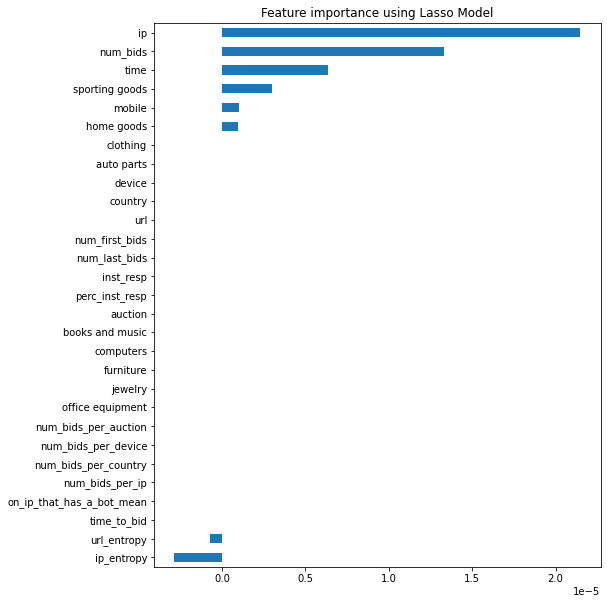

In [96]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LassoCV(alphas=np.arange(0.1, 10, 0.1), cv=cv, n_jobs=-1)

model.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % model.alpha_)
print("Best score using built-in LassoCV: %f" %model.score(X,y))
coef = pd.Series(model.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [80]:
def log_entropy(x):
    e = np.sum(np.log(np.array(range(1,np.sum(x)))))
    first = range(1,np.sum(x))
    second = np.log(np.array(first))
    print('range(1,np.sum(x)): ' + str(first))
    print('last value of first: ' + str(first[-1]))
    print('np.log(np.array(range(1,np.sum(x)))): ' + str(second))
    print('np.sum(np.log(np.array(range(1,np.sum(x))))): ' + str(e))
    
    for i in x:
        e -= np.sum(np.log(np.array(range(1,i))))
    return e

In [81]:
temp_df = bids_df[bids_df['bidder_id'] == "8dac2b259fd1c6d1120e519fb1ac14fbqvax8"]

In [82]:
log_entropy(temp_df.groupby('ip')['ip'].count())

range(1,np.sum(x)): range(1, 62529)
last value of first: 62528
np.log(np.array(range(1,np.sum(x)))): [ 0.          0.69314718  1.09861229 ... 11.04333775 11.04335374
 11.04336974]
np.sum(np.log(np.array(range(1,np.sum(x))))): 627998.2634399784


490367.9005934045

In [84]:
np.log(62528)

11.043369735402454